In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, probplot, levene
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
df_features = pd.read_csv('mice_behavior_capstone/process_data/results/all_the_data.csv')

#Strings to not be considered
arms= ['CL', 'CR', 'OT', 'OB', 'M', 'F1', 'F2', 'F3', 'F4', 'bottom', 'count', '_num_']

In [7]:
#Considers only these features
cols_main= [col for col in df_features.columns if not any(arm in col for arm in arms)]
# cols_main_final = [e for e in cols_main if e not in ('Unnamed: 0', 'inner_directory', 'mouse_details_date', 'mouse_details_mouseID',
#                                               'mouse_details_time',)]

In [8]:
# final_features= [col for col in df_features_final.columns if col not in ('mouse_details_sex', 'mouse_details_strain')]

In [3]:
# In velocity, only active speed considered as closed speed influenced by another features: fraction rest!

final_features= ['fraction_in_arms_closed', 'fraction_in_arms_middle', 'fraction_in_arms_open',
               'mouse_dimensions_mouseLength', 'mouse_dimensions_mouseSize','mouse_dimensions_mouseWidth',
               'peeking_average_length_total', 'peeking_fraction_total',
               'rest_fraction_all_arms', 'rest_fraction_closed_arms', 'rest_fraction_open_arms',
               'safety_and_rest_fraction_closed_arms', 'safety_fraction_closed_arms',
#  'total_distance_closed',
#  'total_distance_open',
               'turning_preferences_fraction_back', 'turning_preferences_fraction_left', 
               'turning_preferences_fraction_right', 'turning_preferences_fraction_straight',
#  'turning_preferences_fraction_back_into_closed',
#  'turning_preferences_fraction_back_into_open',
#  'turning_preferences_fraction_back_only_straight_back',
#  'turning_preferences_fraction_back_only_straight_back_into_closed',
#  'turning_preferences_fraction_back_only_straight_back_into_open',
#  'turning_preferences_fraction_left_into_closed',
#  'turning_preferences_fraction_left_into_open',
#  'turning_preferences_fraction_left_only_right_left',
#  'turning_preferences_fraction_left_only_right_left_into_closed',
#  'turning_preferences_fraction_left_only_right_left_into_open',
#  'turning_preferences_fraction_right_into_closed',
#  'turning_preferences_fraction_right_into_open',
#  'turning_preferences_fraction_right_only_right_left',
#  'turning_preferences_fraction_right_only_right_left_into_closed',
#  'turning_preferences_fraction_right_only_right_left_into_open',
#  'turning_preferences_fraction_straight_into_closed',
#  'turning_preferences_fraction_straight_into_open',
#  'turning_preferences_fraction_straight_only_straight_back',
#  'turning_preferences_fraction_straight_only_straight_back_into_closed',
#  'turning_preferences_fraction_straight_only_straight_back_into_open',
# 'velocity_closed_towards_middle_average_speed',
 'velocity_closed_towards_middle_average_speed_active',
#  'velocity_closed_towards_middle_median_speed',
#  'velocity_closed_towards_middle_median_speed_active',
#  'velocity_closed_towards_outside_average_speed',
 'velocity_closed_towards_outside_average_speed_active',
#  'velocity_closed_towards_outside_median_speed',
#  'velocity_closed_towards_outside_median_speed_active',
#  'velocity_open_towards_middle_average_speed',
 'velocity_open_towards_middle_average_speed_active',
#  'velocity_open_towards_middle_median_speed',
#  'velocity_open_towards_middle_median_speed_active',
#  'velocity_open_towards_outside_average_speed',
 'velocity_open_towards_outside_average_speed_active',]
#  'velocity_open_towards_outside_median_speed',
#  'velocity_open_towards_outside_median_speed_active']

In [4]:
df_bwpo = df_features.loc[(df_features['mouse_details_strain'].isin(['BW', 'PO'])) &
                          (df_features['mouse_details_sex'].isin(['M', 'F'])), :]

In [5]:
df_bwpo.rename(columns = {'fraction_in_arms_open-arms':'fraction_in_arms_open'}, inplace = True)

/Users/srinidhi/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [92]:
def one_factor_significance(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal = [] #Boolean
    normality_p = [] #Tuple of normality test results
    stats_test_p = [] #P values
    significance = [] #Boolean, for significance
    
    for feature in features:

        species1= df.loc[(df['mouse_details_strain']=='BW')&(df[feature]!=0), feature].dropna()
        species2= df.loc[(df['mouse_details_strain']=='PO')&(df[feature]!=0), feature].dropna()

        #Do a Normality test and store p value
        norm1 = shapiro(species1)[1]
        norm2 = shapiro(species2)[1]
        
        #If not normal, do a log transformation
        if min(norm1, norm2) < alpha_normal:
            
            #Check if log tranformation makes data more normal
            if min(shapiro(np.log(species1))[1], shapiro(np.log(species2))[1])> min(norm1, norm2):
                
                print(feature +" -Log done")
                species1= np.log(species1)
                species2= np.log(species2)

                norm1 = shapiro(species1)[1]
                norm2 = shapiro(species2)[1]
        
        normality_p.append((norm1, norm2))
        
        #Conduct a t-test if both distributions are probably sampled from a N(mu, sigma)
        if min(norm1, norm2) > alpha_normal:
            
            normal.append(True)
            
            #Do a t-test(or Anova)
            p = ttest_ind(species1, species2, equal_var= False)[1]
            stats_test_p.append(p)

            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)
        
        #Else, perform a non-parametric test - ideally, not performed if outliers are removed
        else:
            species1= df.loc[(df['mouse_details_strain']=='BW')&(df[feature]!=0), feature].dropna()
            species2= df.loc[(df['mouse_details_strain']=='PO')&(df[feature]!=0), feature].dropna()
            
            normal.append(False)
            p = mannwhitneyu(species1, species2)[1]
            stats_test_p.append(p)
            
            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)

    return normal, normality_p, significance, stats_test_p

In [170]:
def significance_mann(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: p-values for non parametric test (only for non normal features)'''
    
    stats_test_p = []
    for feature in features: 
         #P values
        species1= df.loc[(df['mouse_details_strain']=='BW')&(df[feature]!=0), feature].dropna()
        species2= df.loc[(df['mouse_details_strain']=='PO')&(df[feature]!=0), feature].dropna()
        p = mannwhitneyu(species1, species2)[1]
        stats_test_p.append(p)
    
    return stats_test_p

In [174]:
def one_factor_significance_sex(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal = [] #Boolean
    normality_p = [] #Tuple of normality test results
    stats_test_p = [] #P values
    significance = [] #Boolean, for significance
    
    for feature in features:

        species1= df.loc[(df['mouse_details_sex']=='M')&(df[feature]!=0), feature].dropna()
        species2= df.loc[(df['mouse_details_sex']=='F')&(df[feature]!=0), feature].dropna()

        #Do a Normality test and store p value
        norm1 = shapiro(species1)[1]
        norm2 = shapiro(species2)[1]
        
        #If not normal, do a log transformation
        if min(norm1, norm2) < alpha_normal:
            
            #Check if log tranformation makes data more normal
            if min(shapiro(np.log(species1))[1], shapiro(np.log(species2))[1])> min(norm1, norm2):
                
                print(feature +" -Log done")
                species1= np.log(species1)
                species2= np.log(species2)

                norm1 = shapiro(species1)[1]
                norm2 = shapiro(species2)[1]
        
        normality_p.append((norm1, norm2))
        
        #Conduct a t-test if both distributions are probably sampled from a N(mu, sigma)
        if min(norm1, norm2) > alpha_normal:
            
            normal.append(True)
            
            #Do a t-test(or Anova)
            p = ttest_ind(species1, species2, equal_var= False)[1]
            stats_test_p.append(p)

            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)
        
        #Else, perform a non-parametric test - ideally, not performed if outliers are removed
        else:
            species1= df.loc[(df['mouse_details_sex']=='M')&(df[feature]!=0), feature].dropna()
            species2= df.loc[(df['mouse_details_sex']=='F')&(df[feature]!=0), feature].dropna()
            
            normal.append(False)
            p = mannwhitneyu(species1, species2)[1]
            stats_test_p.append(p)
            
            if p<alpha_significance: 
                significance.append(True)
            else: 
                significance.append(False)

    return normal, normality_p, significance, stats_test_p

In [175]:
normal_sex, normality_p_sex, significance_sex, stats_test_p_sex = one_factor_significance_sex(df_bwpo, features=final_features)

peeking_average_length_total -Log done
peeking_fraction_total -Log done
peeking_median_length_total -Log done
turning_preferences_fraction_back -Log done
turning_preferences_fraction_left -Log done
turning_preferences_fraction_straight -Log done
velocity_closed_towards_middle_average_speed_active -Log done
velocity_closed_towards_middle_median_speed_active -Log done
velocity_closed_towards_outside_average_speed_active -Log done
velocity_closed_towards_outside_median_speed_active -Log done
velocity_open_towards_middle_average_speed_active -Log done
velocity_open_towards_middle_median_speed_active -Log done
velocity_open_towards_outside_average_speed_active -Log done
velocity_open_towards_outside_median_speed_active -Log done


In [171]:
stats_mann_sex= significance_mann(df_bwpo, features=final_features)

In [93]:
normal, normality_p, significance, stats_test_p= one_factor_significance(df_bwpo, features=final_features)

fraction_in_arms_open -Log done
peeking_average_length_total -Log done
peeking_fraction_total -Log done
peeking_median_length_total -Log done
turning_preferences_fraction_back -Log done
turning_preferences_fraction_left -Log done
velocity_closed_towards_middle_average_speed_active -Log done
velocity_closed_towards_middle_median_speed_active -Log done
velocity_closed_towards_outside_average_speed_active -Log done
velocity_closed_towards_outside_median_speed_active -Log done
velocity_open_towards_middle_average_speed_active -Log done
velocity_open_towards_middle_median_speed_active -Log done
velocity_open_towards_outside_average_speed_active -Log done
velocity_open_towards_outside_median_speed_active -Log done


## Results

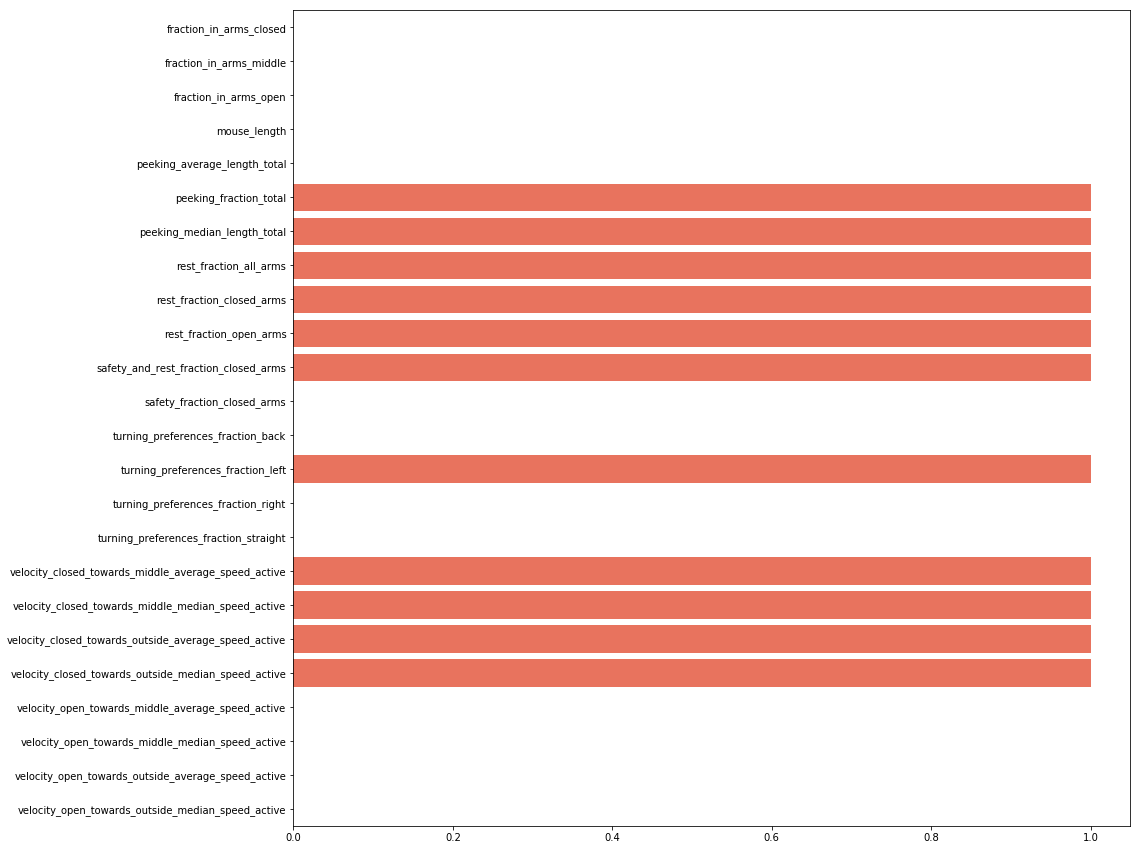

In [94]:
plt.figure(figsize=(15, 15))
sns.barplot(x= normal, y= final_features, color='tomato')
plt.title("")

plt.show()

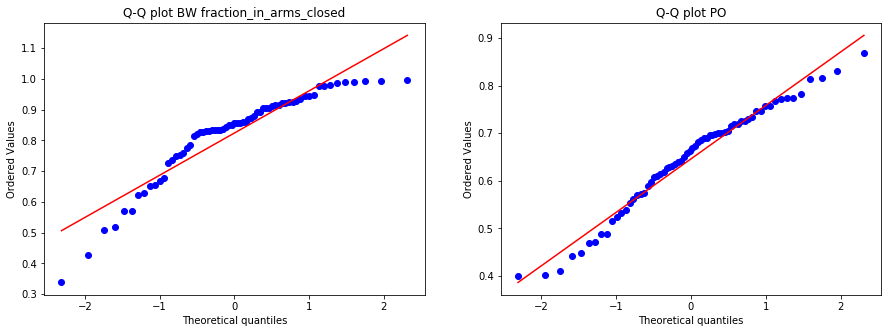

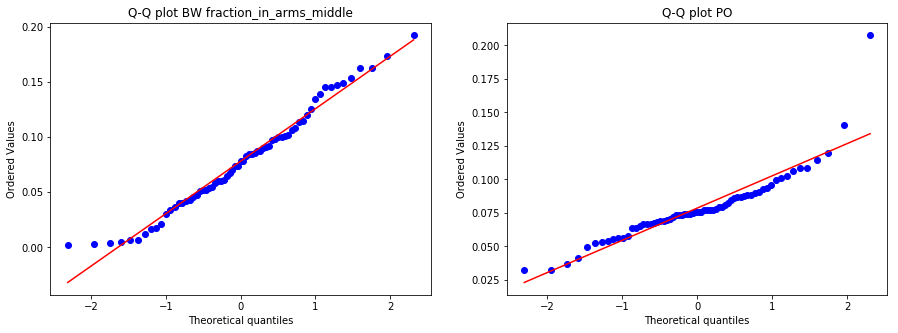

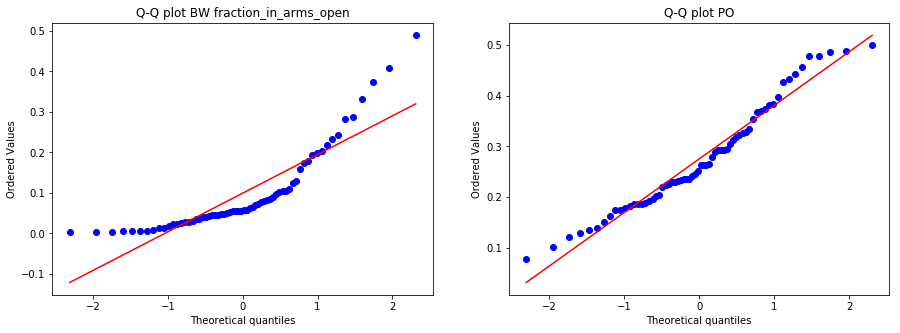

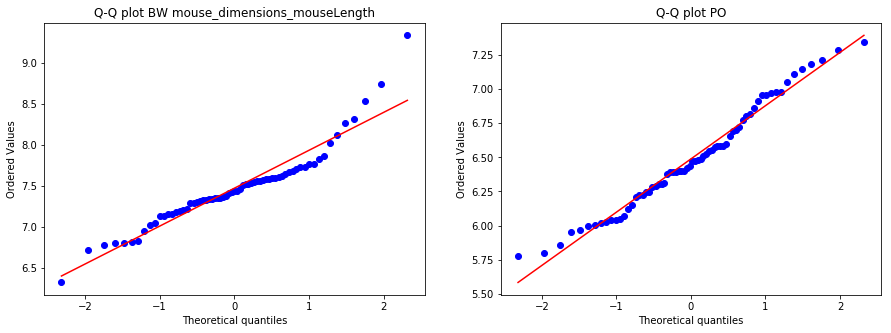

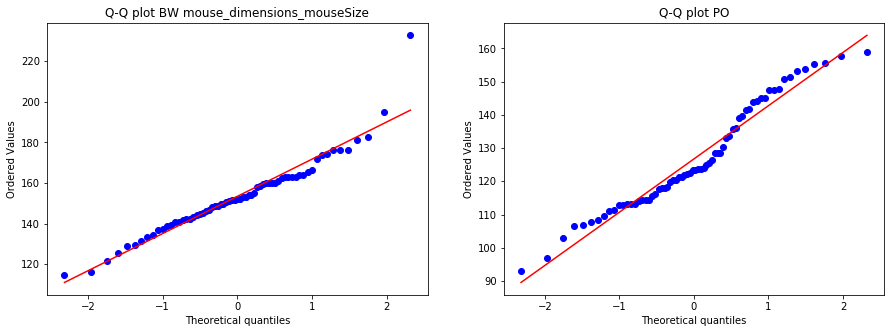

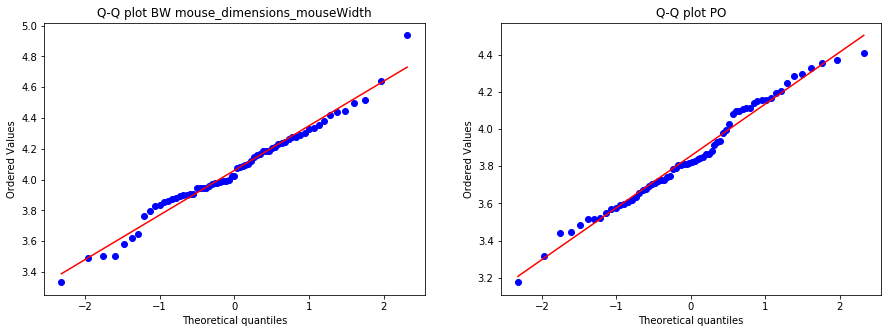

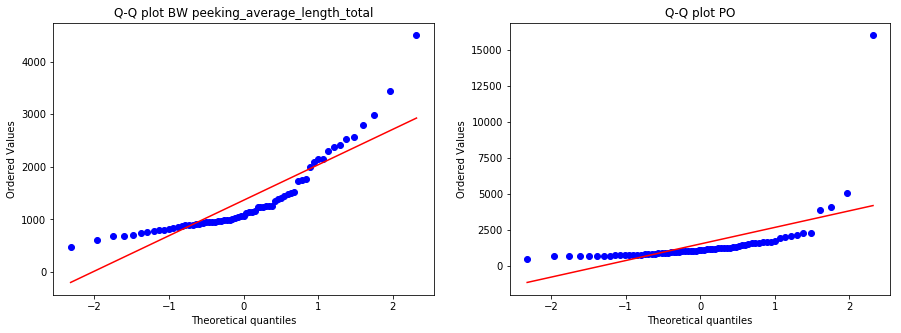

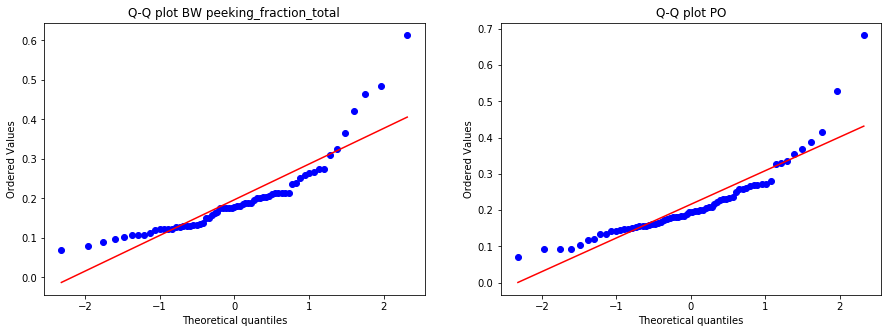

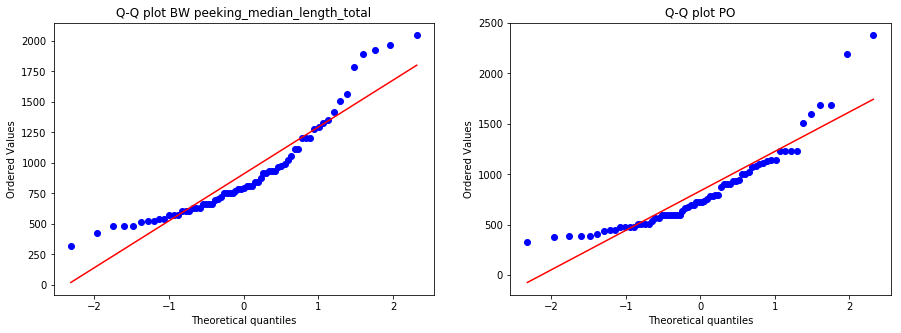

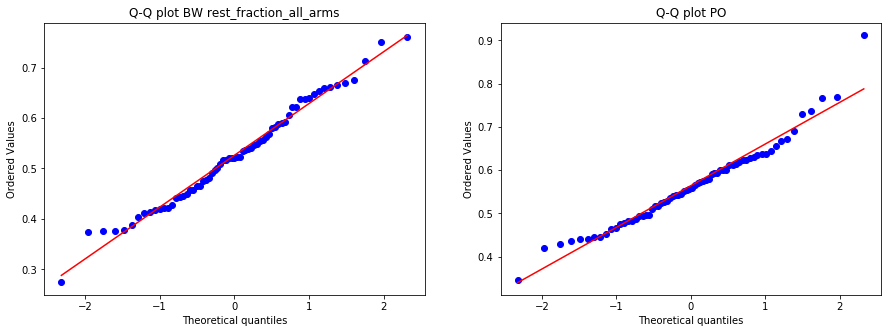

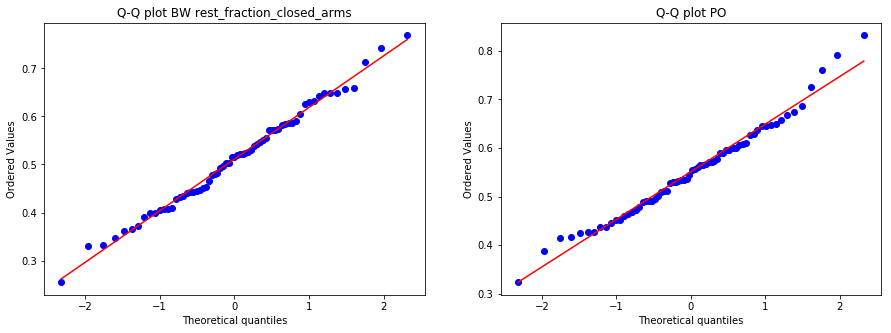

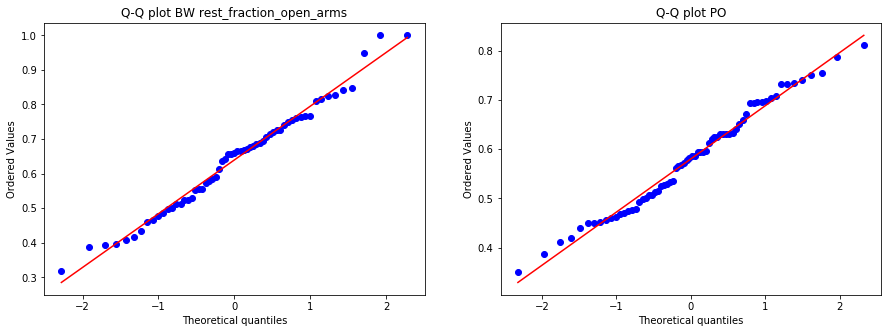

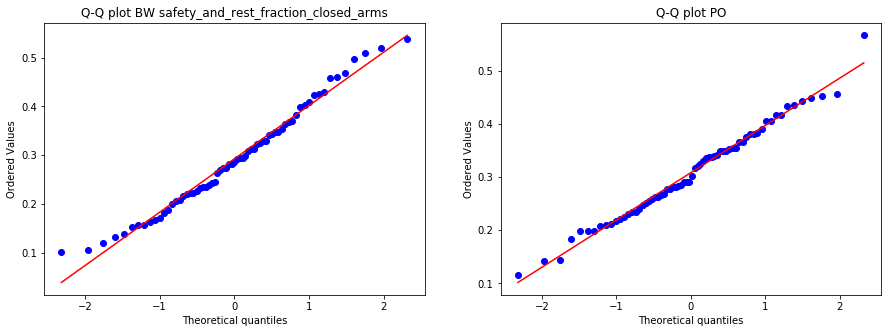

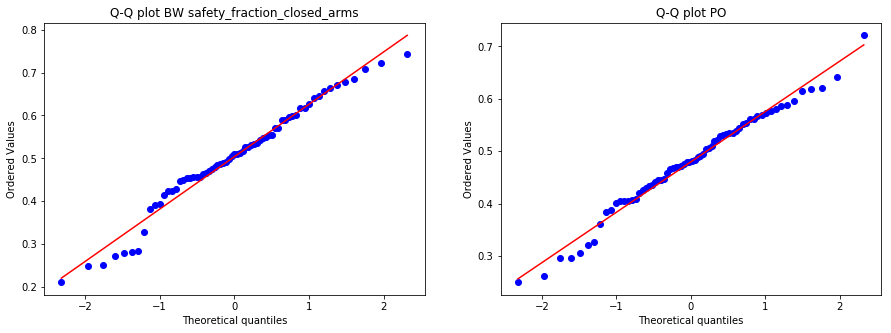

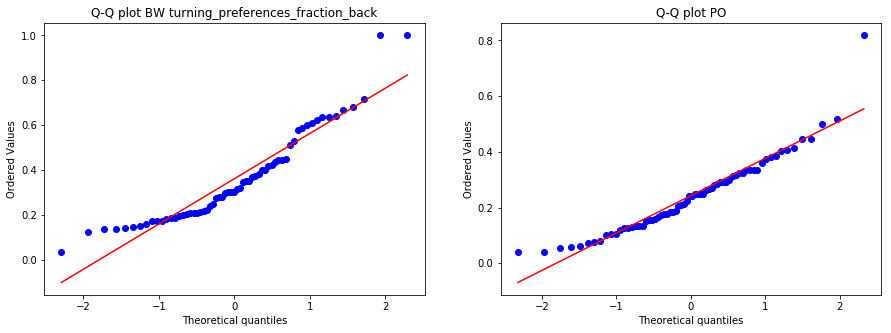

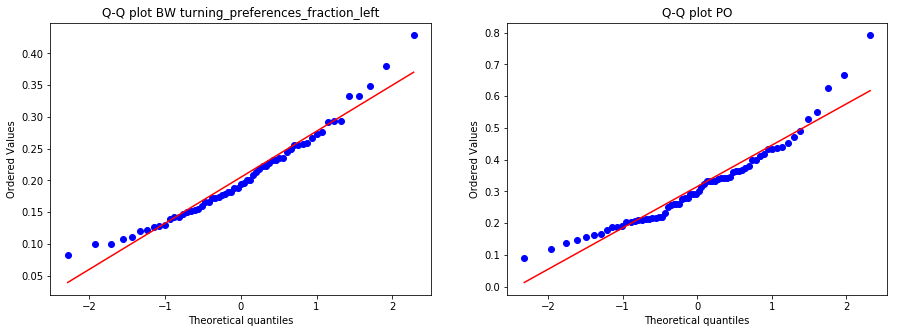

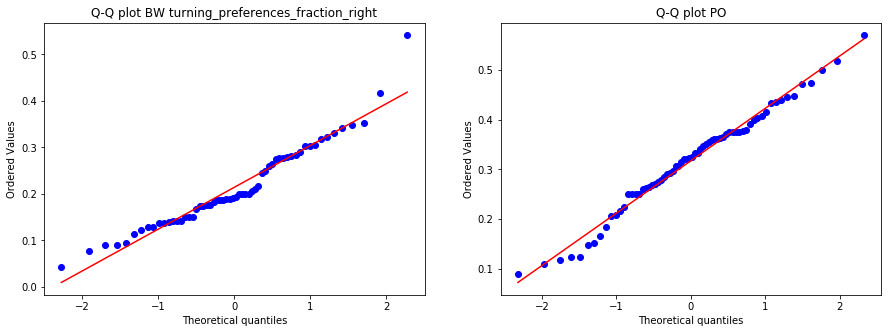

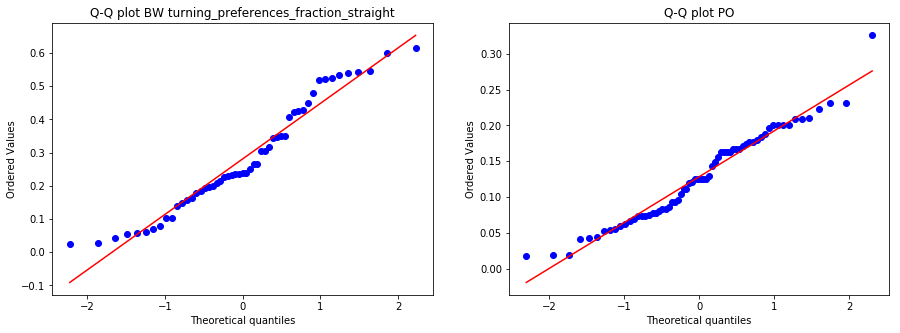

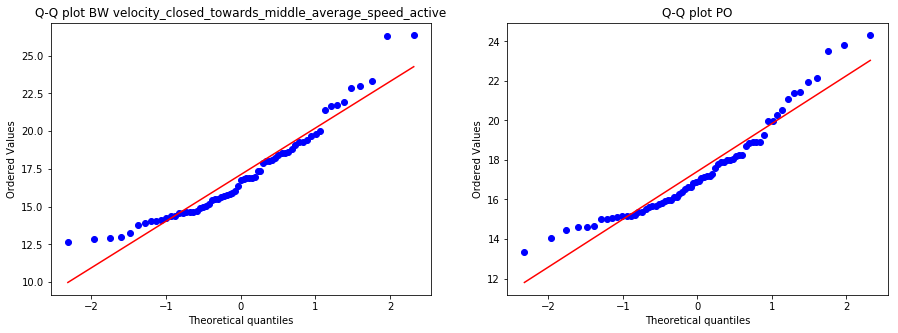

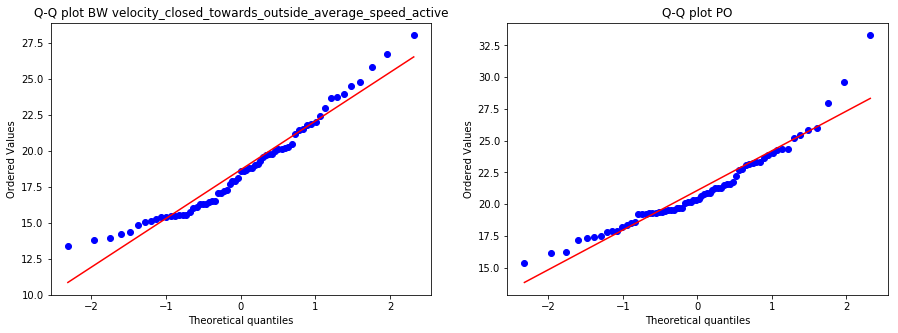

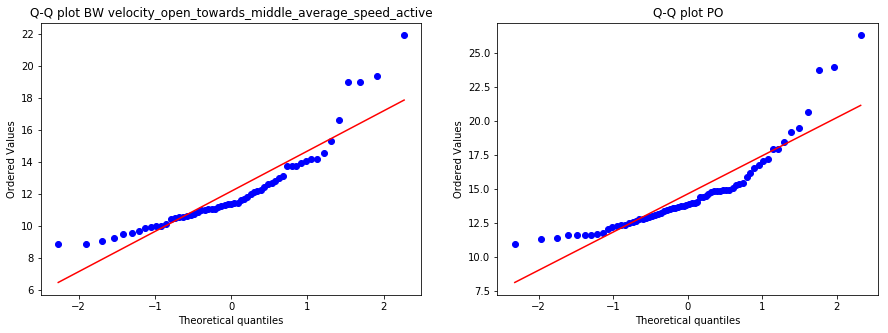

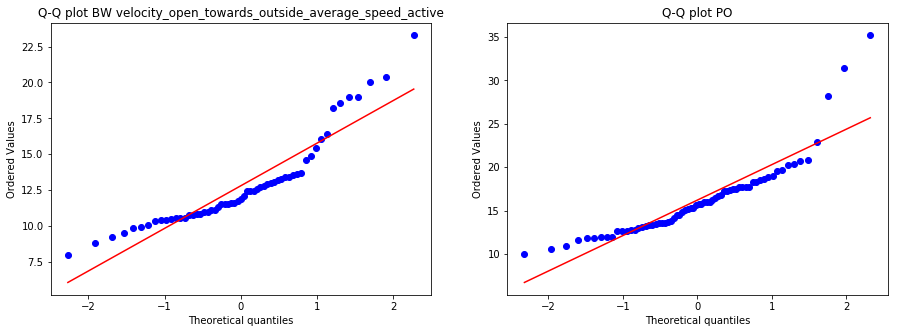

In [13]:
# All Q-Q plots

for feature in final_features:

    plt.subplots(1, 2, figsize=(15, 5))

    plt.subplot(1, 2, 1)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW')&(df_bwpo[feature]!=0), feature].dropna(), dist="norm", plot=pylab)
    plt.title("Q-Q plot BW "+ feature)

    plt.subplot(1, 2, 2)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO')&(df_bwpo[feature]!=0), feature].dropna(), dist="norm", plot=pylab)
    plt.title("Q-Q plot PO")
             
    plt.show()

In [51]:
normality_p

[(5.881685865460895e-05, 0.9658530950546265),
 (0.5112619996070862, 0.00011232830729568377),
 (0.0234952624887228, 3.5107175335724605e-06),
 (0.0030765996780246496, 1.5723051749461092e-09),
 (0.03227872774004936, 0.056877993047237396),
 (0.19577477872371674, 0.16708621382713318),
 (0.34714218974113464, 0.405650794506073),
 (0.890041172504425, 0.15651540458202362),
 (0.9168432354927063, 0.6281934976577759),
 (0.4984835088253021, 0.439205139875412),
 (0.6944689750671387, 0.8522692918777466),
 (0.4188374876976013, 0.031232362613081932),
 (0.017395777627825737, 0.025632426142692566),
 (0.589037299156189, 0.8785815238952637),
 (0.004915708210319281, 0.4003899097442627),
 (0.07544123381376266, 0.0013864595675840974),
 (0.0655960738658905, 0.22641192376613617),
 (0.1382678896188736, 0.10703759640455246),
 (0.12854015827178955, 0.26284971833229065),
 (0.06794632226228714, 0.25235530734062195),
 (0.0021549949888139963, 1.9222232694460217e-08),
 (0.004527068231254816, 7.402626428509862e-11),
 (0

In [165]:
stats_test_p

[1.072878093178137e-13,
 0.04226554072193055,
 2.2620438358259447e-14,
 2.022015127557377e-15,
 0.049569785717938505,
 0.06898827390554842,
 0.5576296895036396,
 0.009882628805418731,
 0.00844590980744413,
 0.020319725117125903,
 0.28349095268776153,
 0.18415579290807949,
 0.01189172882407318,
 1.7181299625167867e-05,
 7.230163063676707e-07,
 1.3243572883569393e-06,
 0.05221447642765974,
 0.2900247538017156,
 1.8823868699210982e-06,
 9.106499415975611e-06,
 9.722675122557064e-07,
 4.0467250618097004e-07,
 2.5743408403727635e-06,
 5.90161735276484e-05]

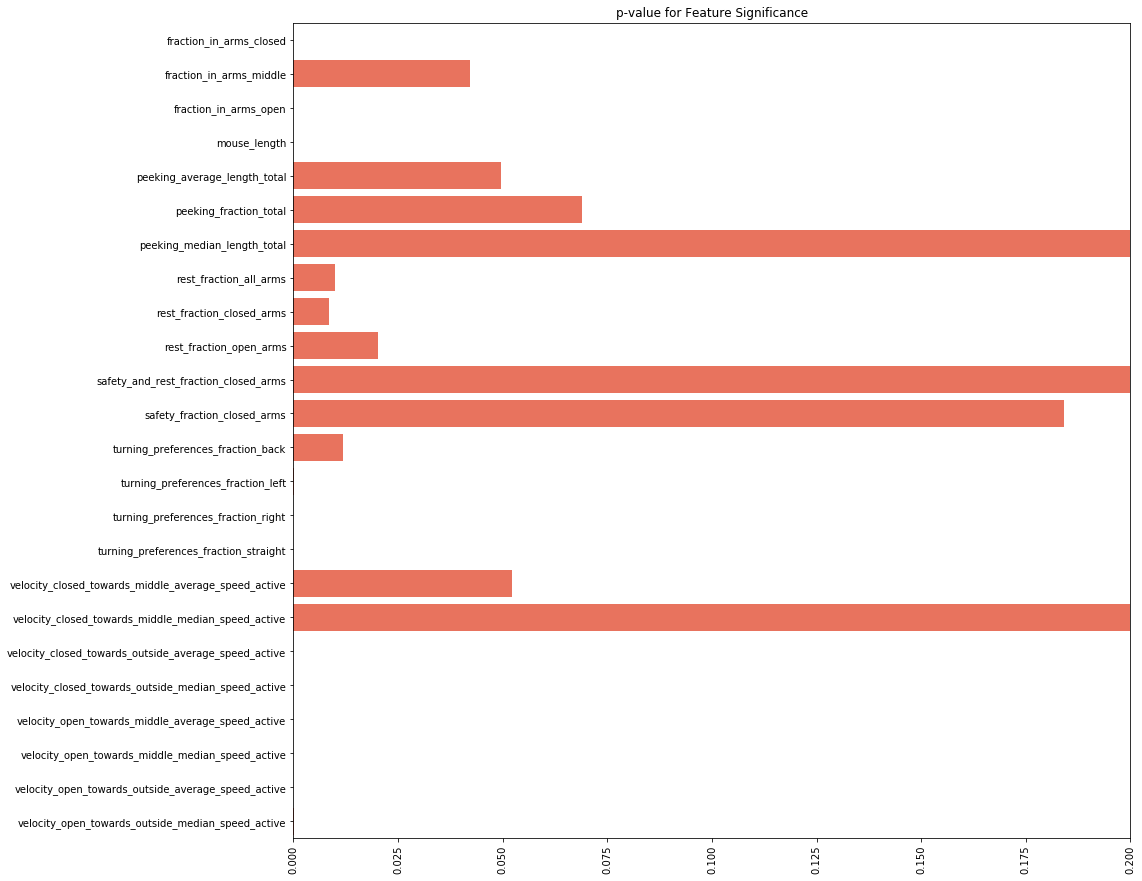

In [95]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance")
sns.barplot(x=stats_test_p, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0,0.2)
plt.show()

In [80]:
np.array(final_features)[np.array(stats_test_p)<0.05]

array(['fraction_in_arms_closed', 'fraction_in_arms_middle',
       'fraction_in_arms_open', 'mouse_length',
       'peeking_average_length_total', 'peeking_fraction_total',
       'peeking_median_length_total', 'rest_fraction_all_arms',
       'rest_fraction_closed_arms', 'rest_fraction_open_arms',
       'safety_and_rest_fraction_closed_arms',
       'safety_fraction_closed_arms', 'turning_preferences_fraction_back',
       'turning_preferences_fraction_left',
       'turning_preferences_fraction_right',
       'turning_preferences_fraction_straight',
       'velocity_closed_towards_middle_average_speed_active',
       'velocity_closed_towards_middle_median_speed_active',
       'velocity_closed_towards_outside_average_speed_active',
       'velocity_closed_towards_outside_median_speed_active',
       'velocity_open_towards_middle_average_speed_active',
       'velocity_open_towards_middle_median_speed_active',
       'velocity_open_towards_outside_average_speed_active',
       'velo

1. Mouse length
2. Fraction of time(Open arms, Closed arms, Middle)
3. Turn Preference(Left, Right, Straight, Back)
4. Rest Fraction(Close Arms, Open Arms, All Arms)
5. Active_Velocities(Close->Outside, Open->Outside, Open->back)

## Example where Log transformation works

In [10]:
df_features_final= df_features.dropna()

In [ ]:
df_bwpo['velocity_open_towards_middle_median_speed_active']

## Outlier Effect

In [87]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'velocity_open_towards_middle_median_speed_active'])[1])
print(shapiro(sorted(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'velocity_open_towards_middle_median_speed_active'])[:-1])[1])

7.622576547283537e-15
0.9803978800773621


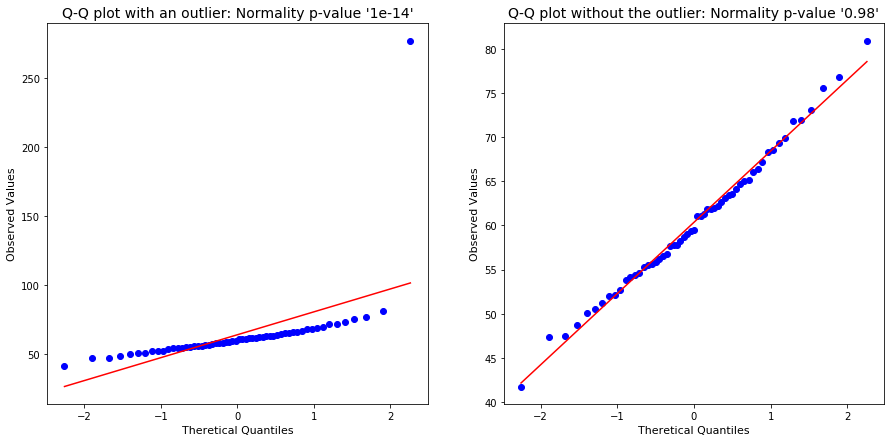

In [121]:
plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1, 2, 1)
probplot(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'velocity_open_towards_middle_median_speed_active'], dist="norm", plot=pylab)
plt.title("Q-Q plot with an outlier: Normality p-value '1e-14'", fontsize=14)
plt.xlabel('Theretical Quantiles', fontsize=11)
plt.ylabel('Observed Values', fontsize=11)

plt.subplot(1, 2, 2)
probplot(sorted(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'velocity_open_towards_middle_median_speed_active'])[:-1], dist="norm", plot=pylab)
plt.title("Q-Q plot without the outlier: Normality p-value '0.98'", fontsize=14)
plt.xlabel('Theretical Quantiles', fontsize=11)
plt.ylabel('Observed Values' ,fontsize=11)

plt.show()

In [127]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total'])[1])
print(shapiro(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total']))[1])

5.000780447517172e-07
0.19577477872371674


/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


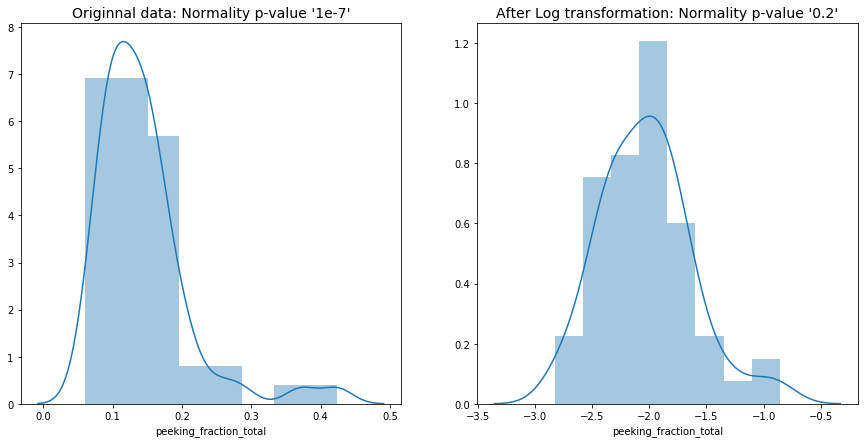

In [130]:
# Not Normal
plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Originnal data: Normality p-value '1e-7'", fontsize=14)
sns.distplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total'], bins=8)

# Mostly Normal
plt.subplot(1, 2, 2)
plt.title("After Log transformation: Normality p-value '0.2'", fontsize=14)
sns.distplot(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total']), bins=8)
plt.show()

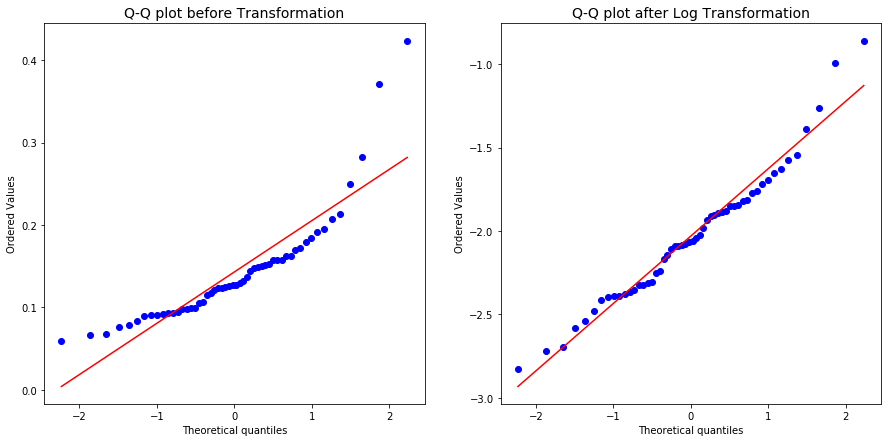

In [131]:
plt.subplots(1, 2, figsize=(15, 7))

plt.subplot(1, 2, 1)
probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total'], dist="norm", plot=pylab)
plt.title("Q-Q plot before Transformation", fontsize=14)

plt.subplot(1, 2, 2)
probplot(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') & 
                         (df_bwpo['peeking_fraction_total']!=0), 'peeking_fraction_total']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Log Transformation", fontsize=14)

plt.show()

## Negative effect of outliers 
- Log transformation won't work as Shapiro wilk test is very sensitive

In [24]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[1])
print(shapiro(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']))[1])

9.785273505258374e-06
0.0027029169723391533


/Users/srinidhi/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


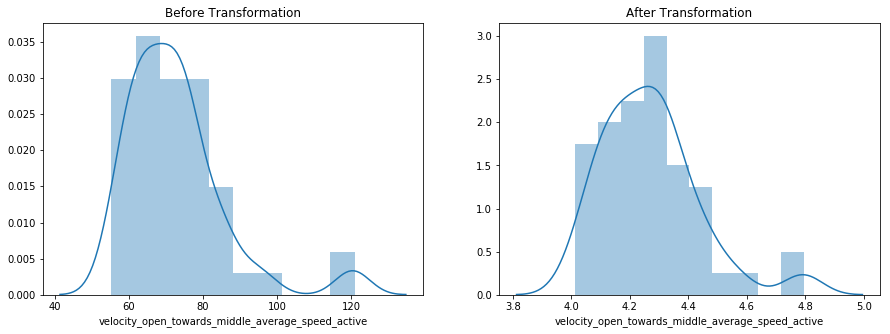

In [25]:
# Not Normal
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Before Transformation")
sns.distplot(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'], bins=10)

# Mostly Normal
plt.subplot(1, 2, 2)
plt.title("After Transformation")
sns.distplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']), bins=10)
plt.show()

#The RHS mostly looks normal except those outliers around 8.5

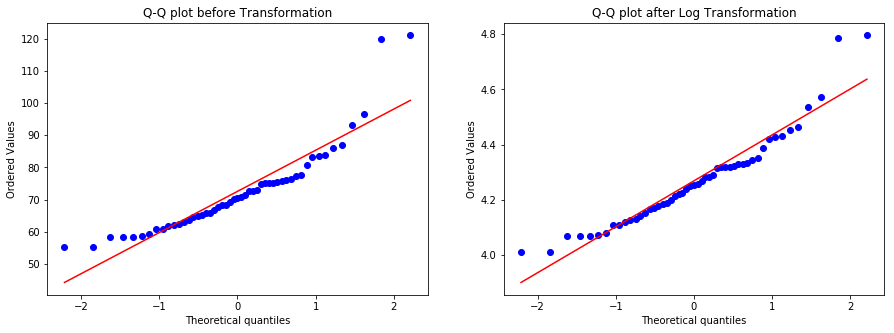

In [26]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'], dist="norm", plot=pylab)
plt.title("Q-Q plot before Transformation")

plt.subplot(1, 2, 2)
probplot(np.log(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active']), dist="norm", plot=pylab)
plt.title("Q-Q plot after Log Transformation")

plt.show()

#Outliers clearly seen!


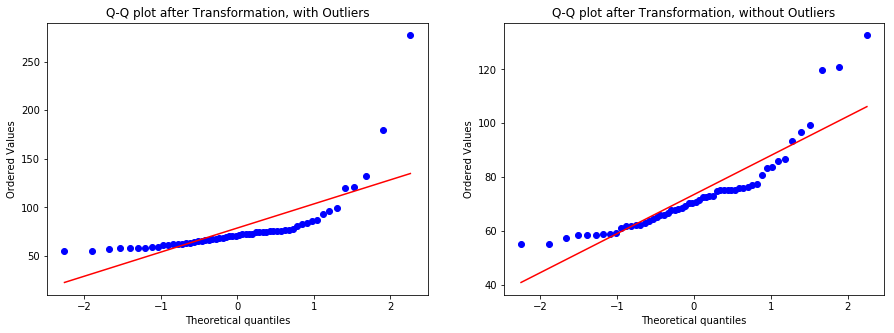

In [83]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO')&(df_bwpo['velocity_open_towards_middle_average_speed_active']!=0),
                     'velocity_open_towards_middle_average_speed_active'].dropna(), dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, with Outliers")

plt.subplot(1, 2, 2)
probplot(sorted(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO')&(df_bwpo['velocity_open_towards_middle_average_speed_active']!=0),
                     'velocity_open_towards_middle_average_speed_active'].dropna())[:-2], dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, without Outliers")

plt.show()

In [28]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[1])
print(shapiro(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_middle_average_speed_active'])[:-2]))[1])

#Outlier removal clearly helped!


9.785273505258374e-06
0.5203026533126831


In [35]:
#p-values of normality test (higher the p value, higher is the probability of the underlying distribution being Normal)
print(shapiro(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_outside_average_speed_active'])[1])
print(shapiro(np.log(sorted(df_features_final.loc[df_features_final['mouse_details_strain']=='PO', 'velocity_open_towards_outside_average_speed_active'])[:-2]))[1])

#Outlier removal clearly helped!


1.2264216309176845e-08
0.46230748295783997


## Other Issues

'fraction_in_arms_closed' - different distributions for BW and PO - can't do any transformation

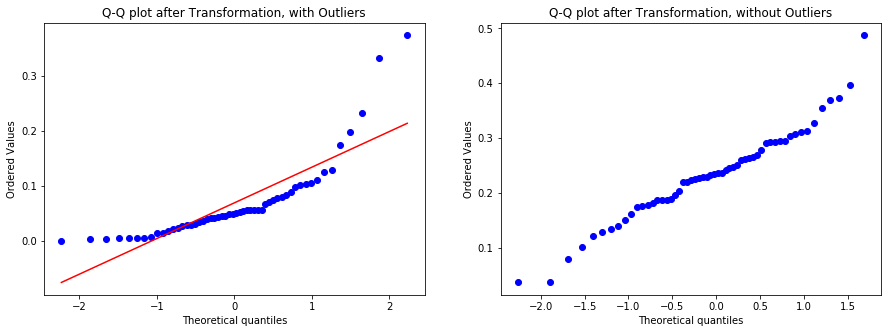

In [135]:
plt.subplots(1, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
probplot(df_bwpo.loc[df_bwpo['mouse_details_strain']=='BW', 'fraction_in_arms_open'], dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, with Outliers")

plt.subplot(1, 2, 2)
probplot(df_bwpo.loc[df_bwpo['mouse_details_strain']=='PO', 'fraction_in_arms_open'], dist="norm", plot=pylab)
plt.title("Q-Q plot after Transformation, without Outliers")

plt.show()

In [112]:
np.array(final_features)[stats_test_p<np.full(len(stats_test_p), 0.05)]

array(['fraction_in_arms_closed', 'fraction_in_arms_open-arms',
       'mouse_length', 'peeking_average_length_total',
       'peeking_median_length_total', 'rest_fraction_all_arms',
       'rest_fraction_closed_arms',
       'safety_and_rest_fraction_closed_arms',
       'turning_preferences_fraction_left',
       'turning_preferences_fraction_right',
       'turning_preferences_fraction_straight',
       'velocity_closed_towards_middle_median_speed',
       'velocity_closed_towards_outside_median_speed',
       'velocity_closed_towards_outside_median_speed_active',
       'velocity_open_towards_middle_median_speed_active',
       'velocity_open_towards_outside_median_speed',
       'velocity_open_towards_outside_median_speed_active'], dtype='<U51')

# Two Factor Analysis

In [6]:
# To determine if ANOVA conditions are satisfied

def anova_conditions(df, features, alpha_normal=0.05, alpha_significance=0.05):

    ''' significance(df_features, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results
    normal_count = [] #Number of normal dist.
#     normality_panova = [] #Tuple of normality test results
    std=[] #Levene's test
    std_log=[]

    for feature in features:
        
        sample1= df.loc[(df['mouse_details_strain']== 'BW') & (df['mouse_details_sex'] == 'M')
                        & (df[feature]!=0), feature].dropna()
        sample2= df.loc[(df['mouse_details_strain']== 'BW') & (df['mouse_details_sex'] == 'F')
                        &(df[feature]!=0), feature].dropna() 
        sample3= df.loc[(df['mouse_details_strain']== 'PO') & (df['mouse_details_sex'] == 'M')
                        &(df[feature]!=0), feature].dropna()
        sample4= df.loc[(df['mouse_details_strain']== 'PO') & (df['mouse_details_sex'] == 'F')
                        &(df[feature]!=0), feature].dropna()
        
        #Do a Normality test and store p value
        norm1 = shapiro(sample1)[1]
        norm2 = shapiro(sample2)[1]
        norm3 = shapiro(sample3)[1]
        norm4 = shapiro(sample4)[1]
        
        norm_original = np.sum(np.array([norm1, norm2, norm3, norm4])>0.05)
        norm_log = np.sum(np.array([shapiro(np.log(sample1))[1], shapiro(np.log(sample2))[1], 
                                   shapiro(np.log(sample3))[1], shapiro(np.log(sample4))[1]])>0.05)
        norm_sq = np.sum(np.array([np.square(shapiro(sample1))[1], np.square(shapiro(sample2))[1], 
                                  np.square(shapiro(sample3))[1], np.square(shapiro(sample4)[1])])>0.05)
        
        normal_count.append((norm_original, norm_log, norm_sq))
        std.append(levene(sample1, sample2, sample3, sample4)[1])
        
        std_log.append(levene(np.log(sample1), np.log(sample2), np.log(sample3), np.log(sample4))[1])
        
    return normal_count, std, std_log#, significance, stats_test_p

In [7]:
normal_count, std, std_log = anova_conditions(df_bwpo, features=final_features)

In [8]:
final_features

['fraction_in_arms_closed',
 'fraction_in_arms_middle',
 'fraction_in_arms_open',
 'mouse_dimensions_mouseLength',
 'mouse_dimensions_mouseSize',
 'mouse_dimensions_mouseWidth',
 'peeking_average_length_total',
 'peeking_fraction_total',
 'peeking_median_length_total',
 'rest_fraction_all_arms',
 'rest_fraction_closed_arms',
 'rest_fraction_open_arms',
 'safety_and_rest_fraction_closed_arms',
 'safety_fraction_closed_arms',
 'turning_preferences_fraction_back',
 'turning_preferences_fraction_left',
 'turning_preferences_fraction_right',
 'turning_preferences_fraction_straight',
 'velocity_closed_towards_middle_average_speed_active',
 'velocity_closed_towards_outside_average_speed_active',
 'velocity_open_towards_middle_average_speed_active',
 'velocity_open_towards_outside_average_speed_active']

In [9]:
normal_count

[(1, 0, 1),
 (3, 1, 2),
 (1, 4, 1),
 (2, 3, 2),
 (2, 2, 1),
 (4, 3, 1),
 (1, 1, 0),
 (0, 4, 0),
 (0, 4, 0),
 (4, 4, 1),
 (4, 4, 4),
 (4, 4, 3),
 (4, 4, 4),
 (4, 1, 4),
 (0, 3, 0),
 (3, 4, 2),
 (3, 1, 2),
 (3, 1, 0),
 (1, 4, 0),
 (3, 3, 1),
 (0, 1, 0),
 (1, 2, 0)]

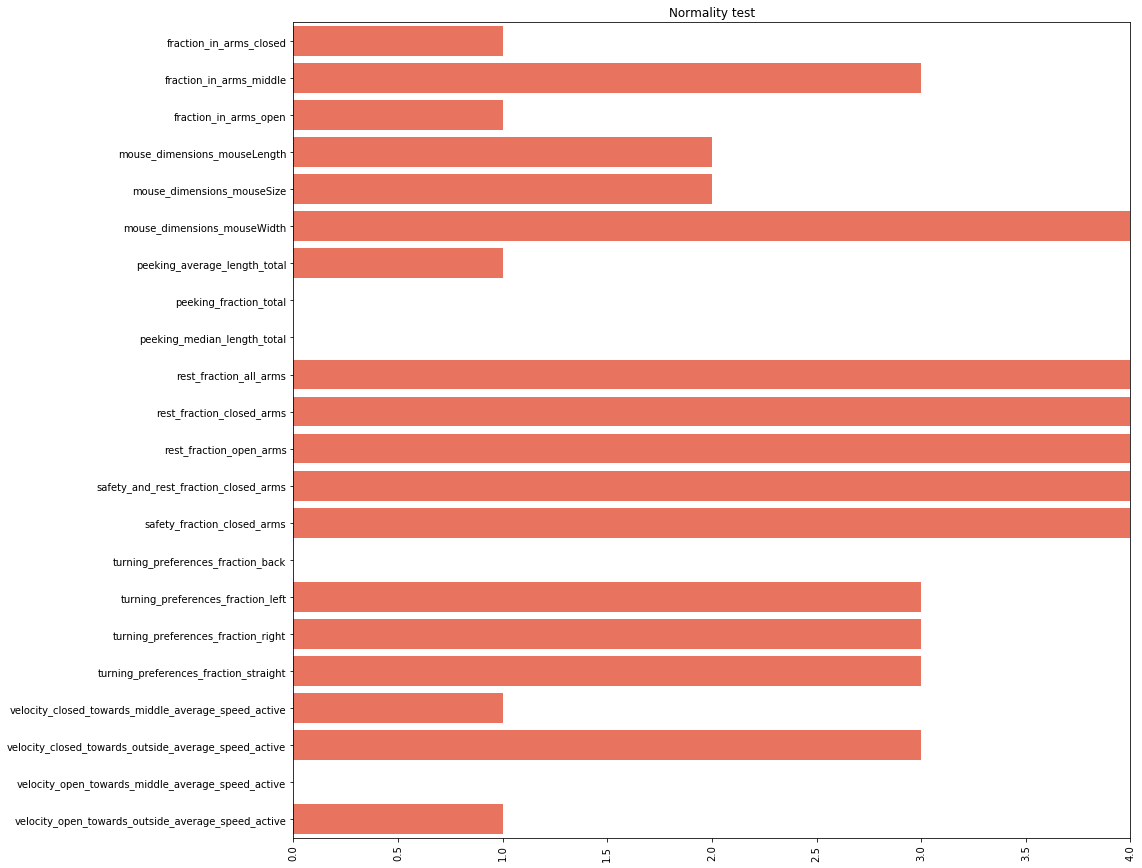

In [10]:
plt.figure(figsize=(15, 15))
plt.title("Normality test")
sns.barplot(x=[norm[0] for norm in normal_count], y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 4)
plt.show()

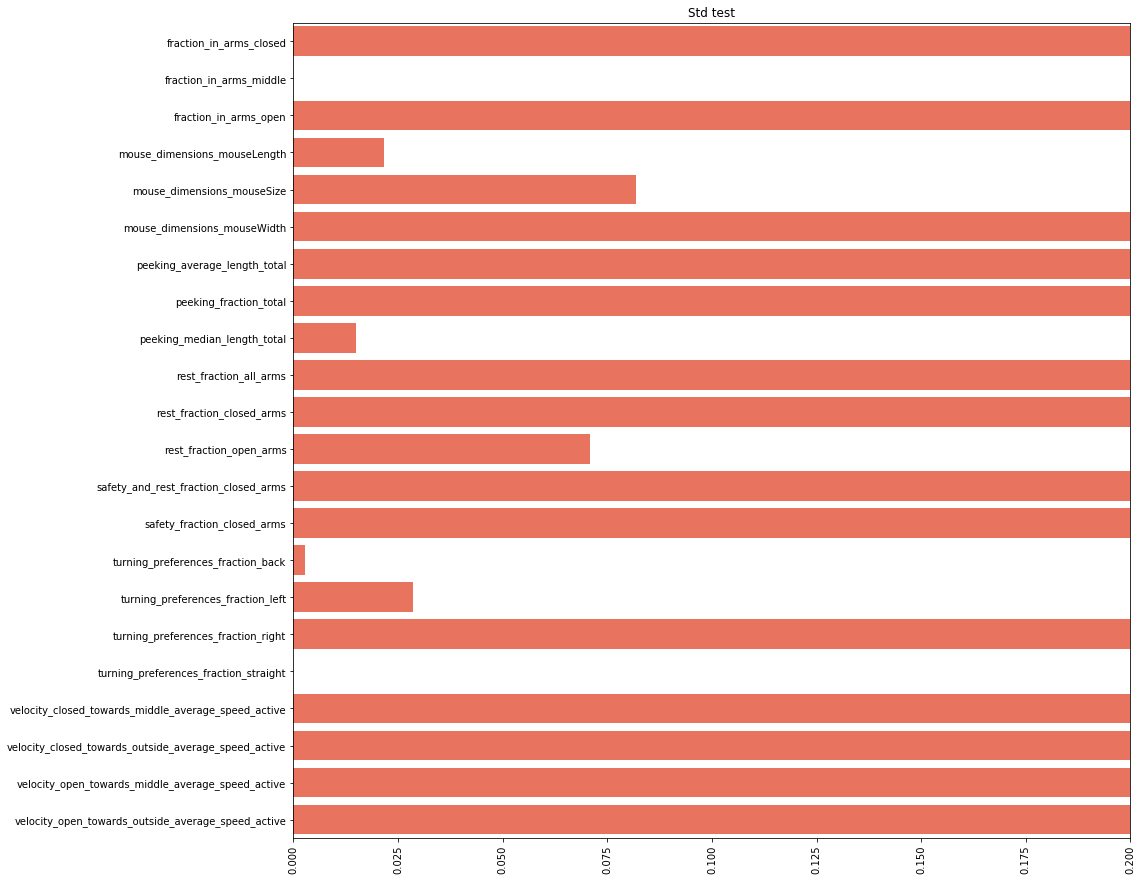

In [11]:
plt.figure(figsize=(15, 15))
plt.title("Std test")
sns.barplot(x=std, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0,0.2)
plt.show()

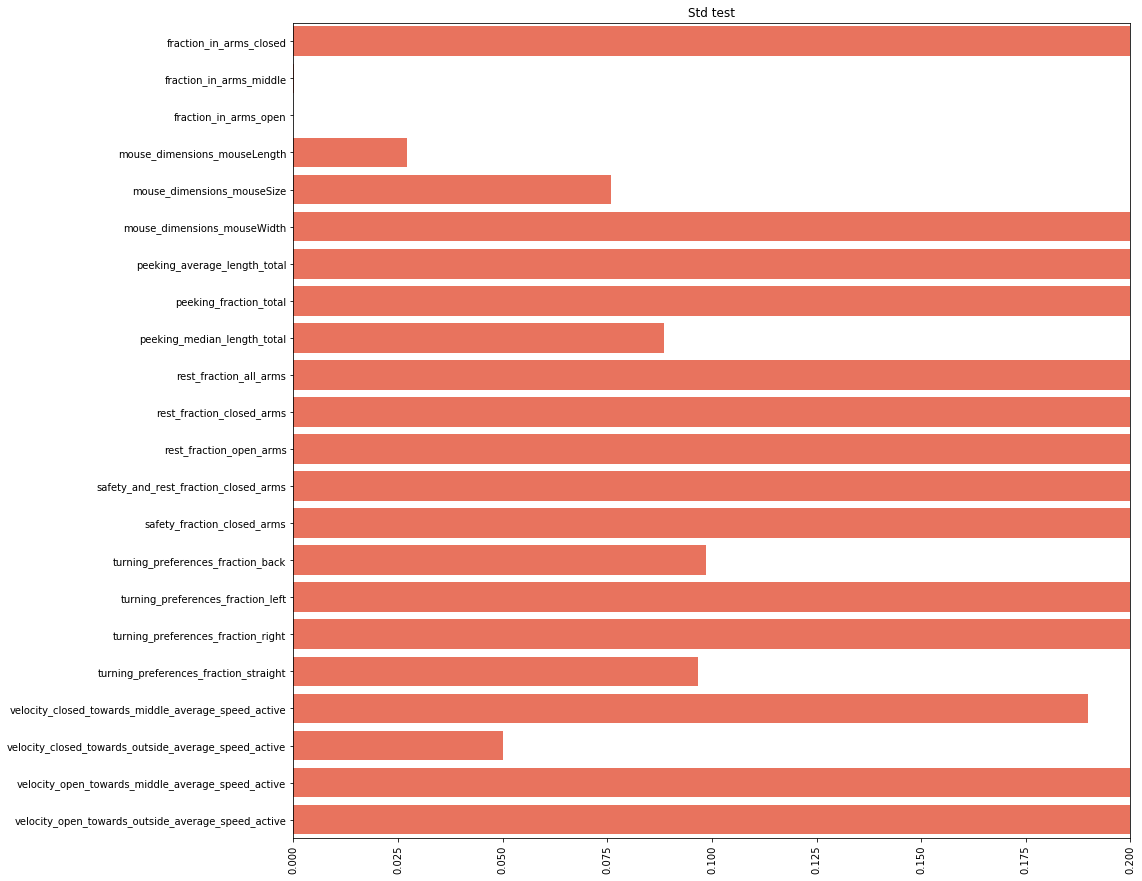

In [12]:
plt.figure(figsize=(15, 15))
plt.title("Std test")
sns.barplot(x=std_log, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0,0.2)
plt.show()

In [ ]:
Normal: [‘fraction_in_arms_middle’, 
         ‘mouse_dimensions_mouseLength’, ‘mouse_dimensions_mouseWidth’, ‘mouse_dimensions_mouseSize’,
      ‘rest_fraction_all_arms’, ‘rest_fraction_closed_arms’, ‘rest_fraction_open_arms’, 
        ‘turning_preferences_fraction_left’,
      ‘turning_preferences_fraction_right’,
      ‘turning_preferences_fraction_straight’, ‘turning_preferences_fraction_back’,
      ‘velocity_closed_towards_outside_average_speed_active’, 
      ‘velocity_closed_towards_middle_average_speed_active’]

Normal with log: ['fraction_in_arms_open', ‘velocity_open_towards_middle_average_speed_active’,
      ‘velocity_open_towards_outside_average_speed_active’]

Not normal with any transformation: ['fraction_in_arms_closed', ]

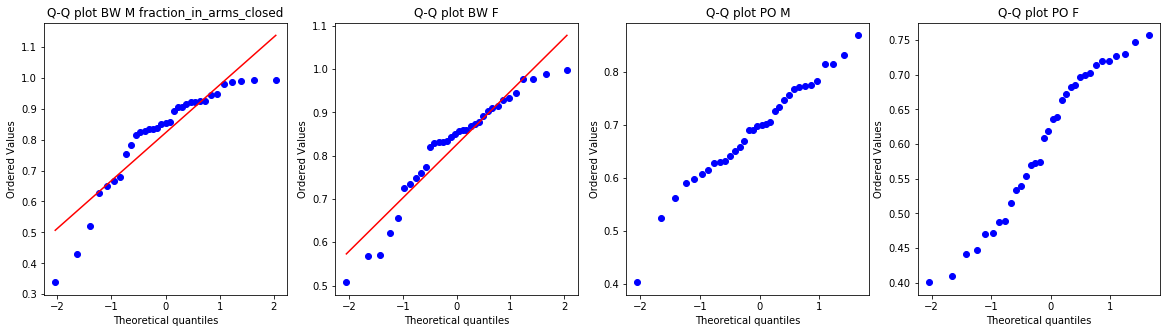

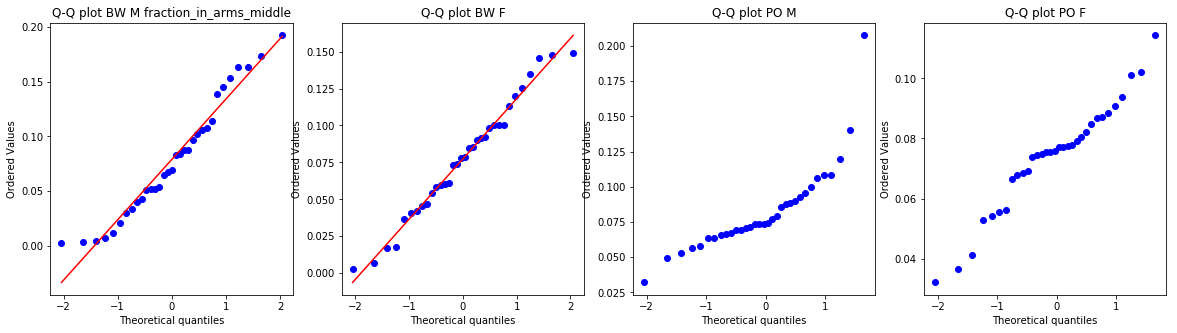

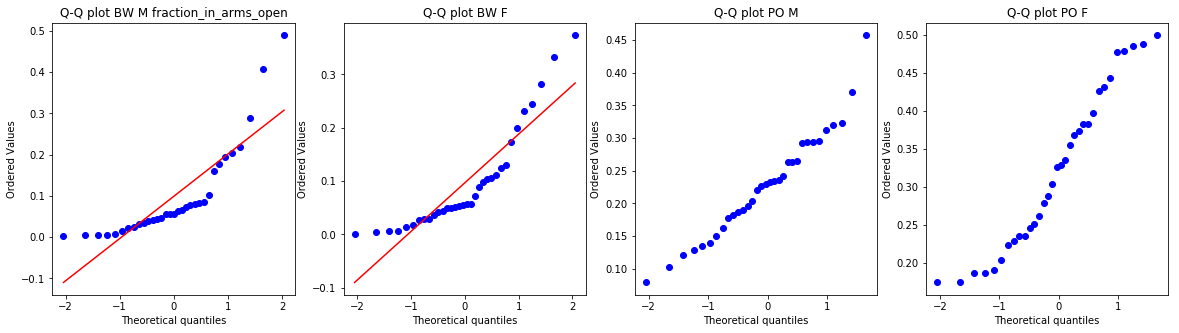

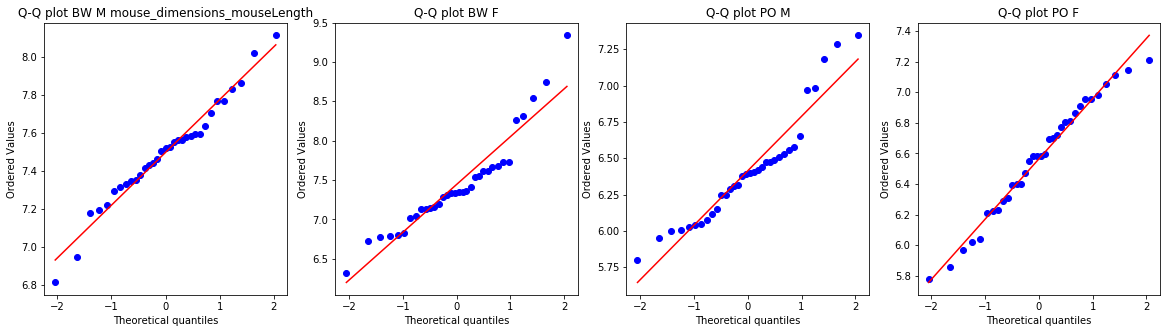

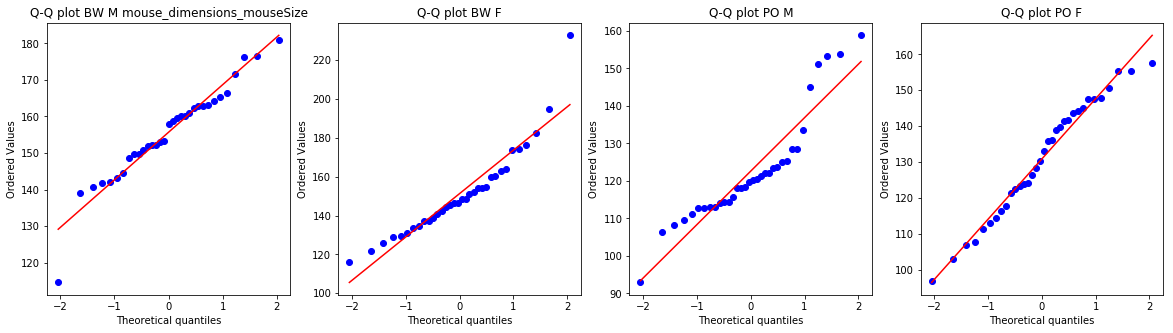

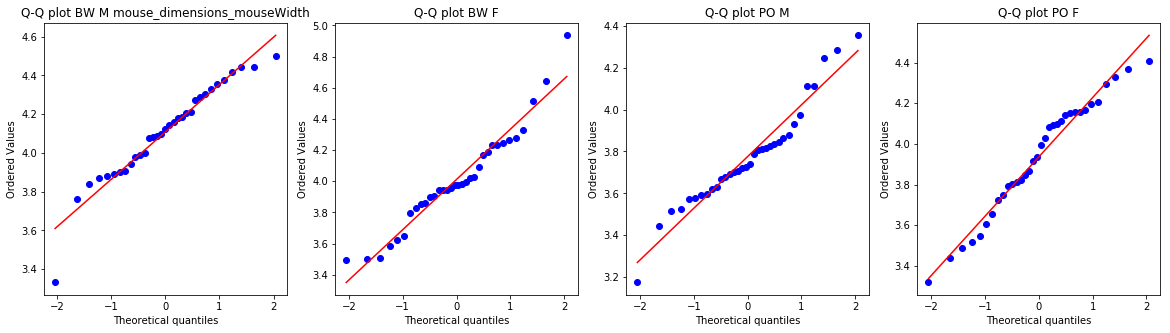

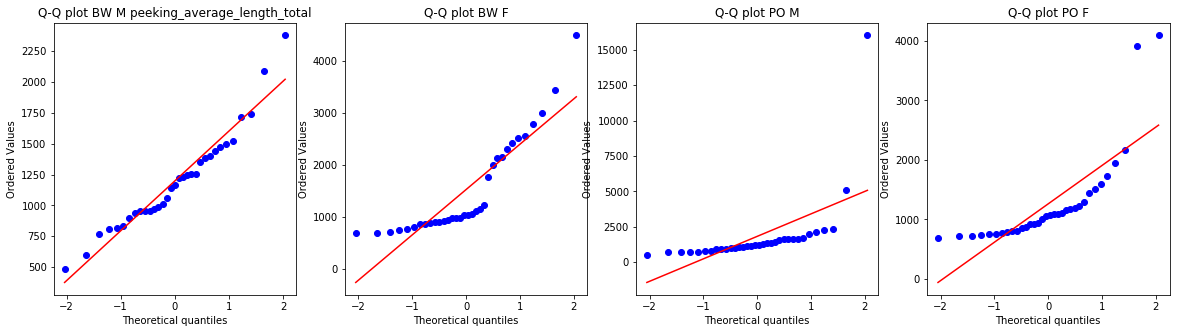

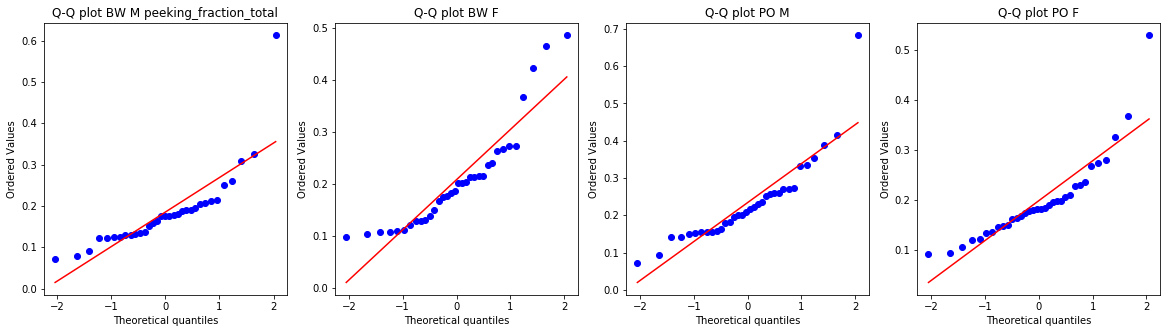

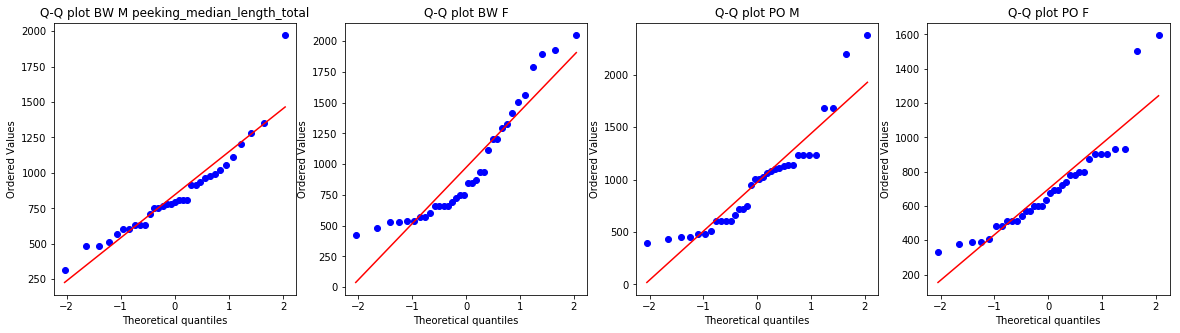

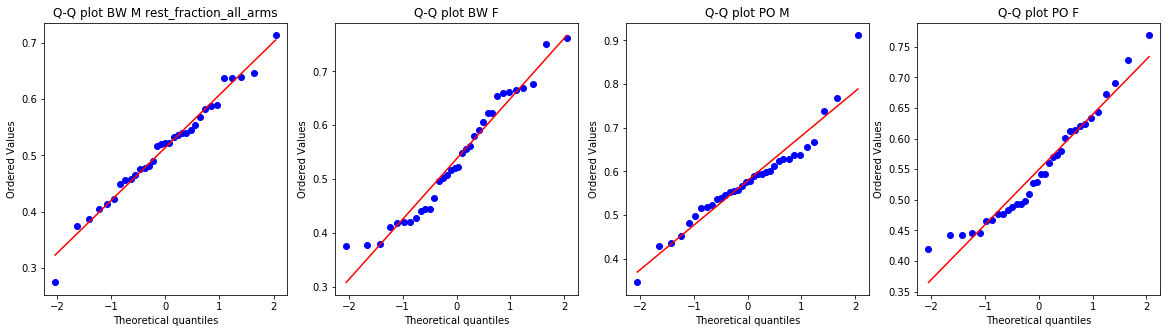

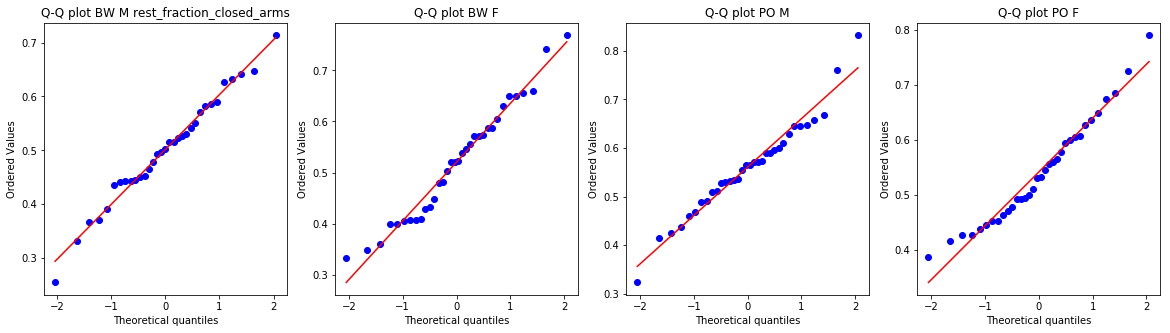

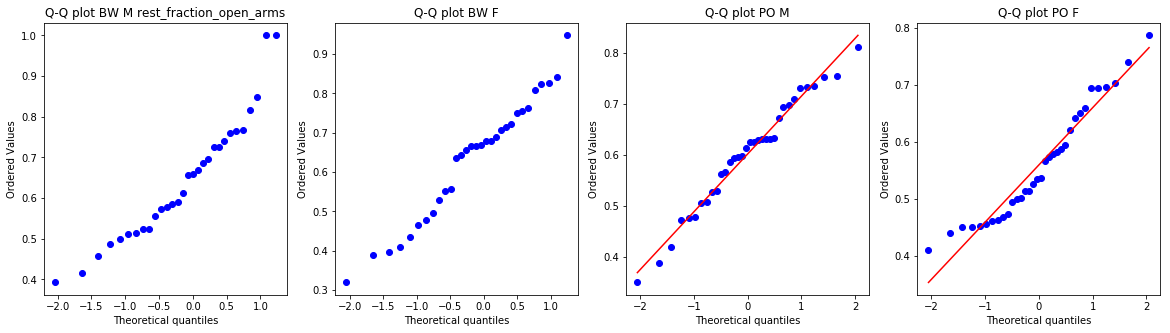

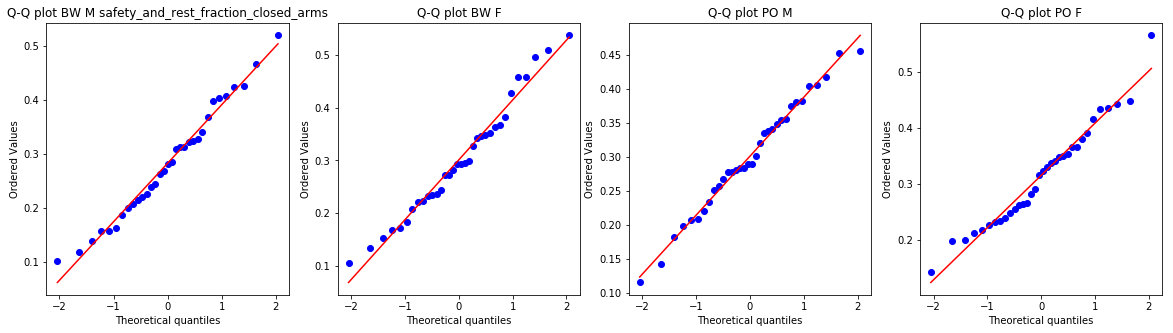

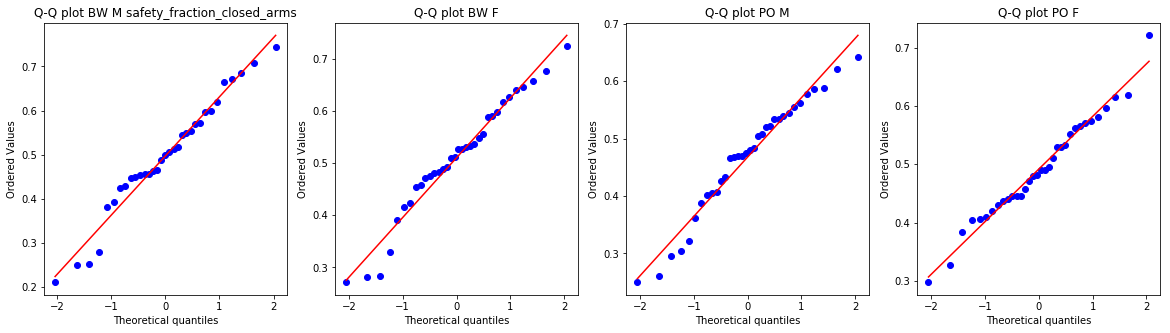

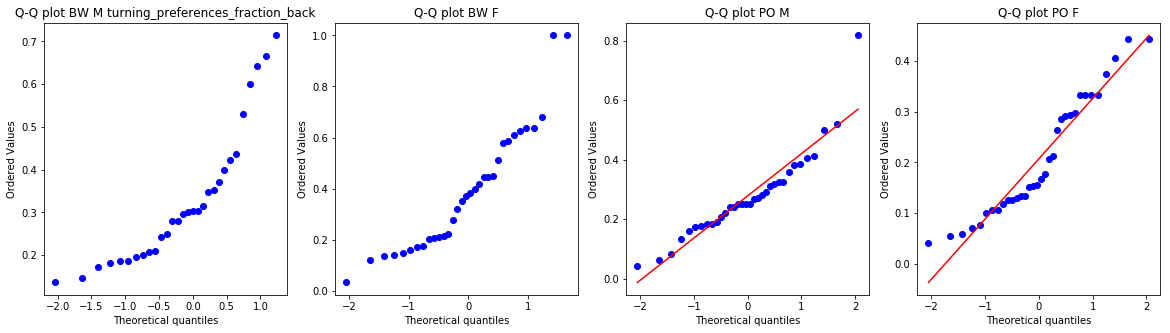

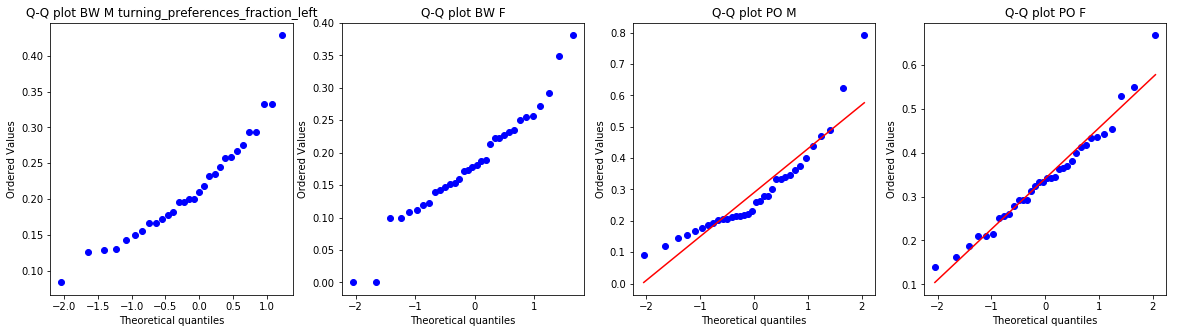

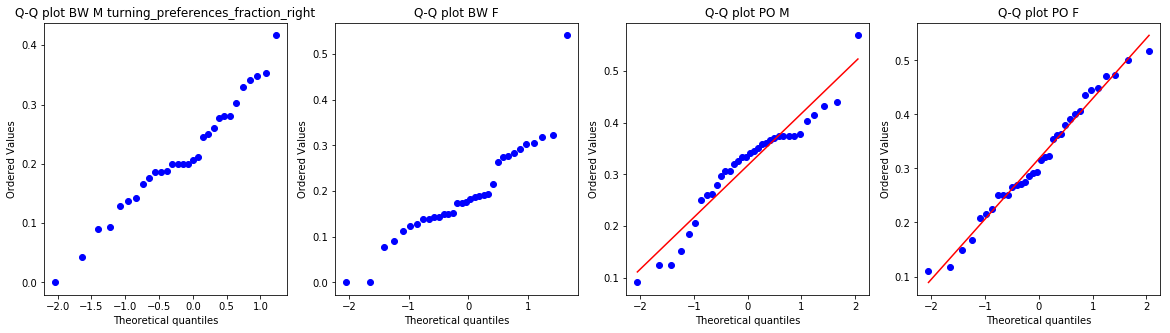

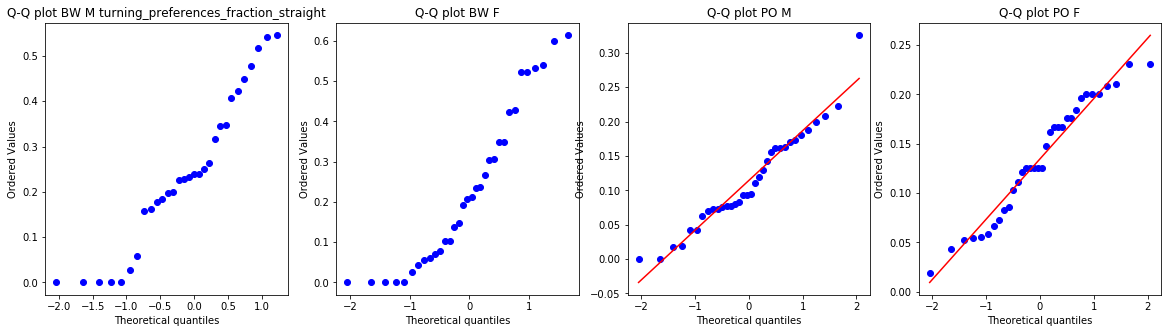

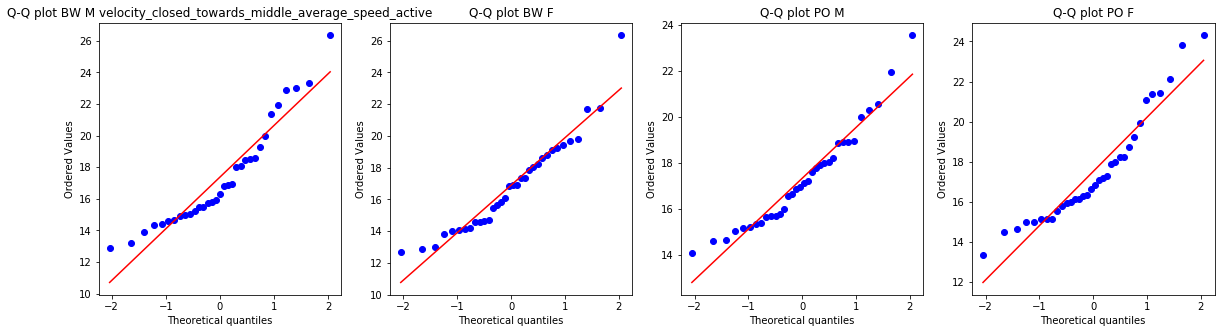

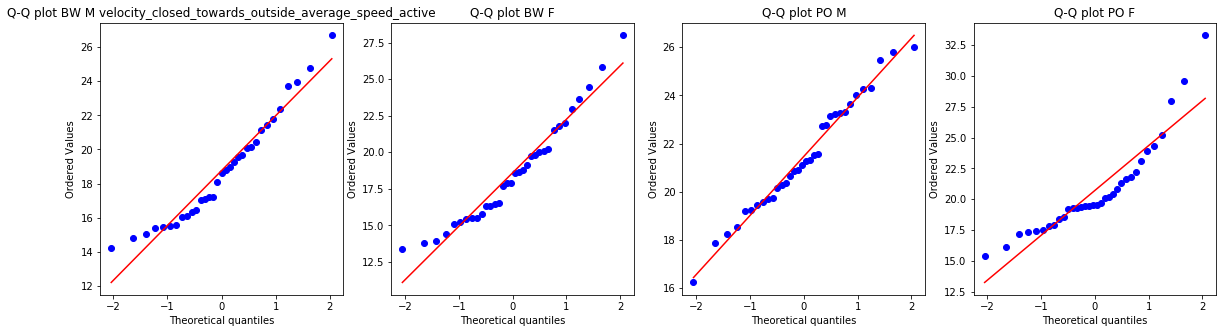

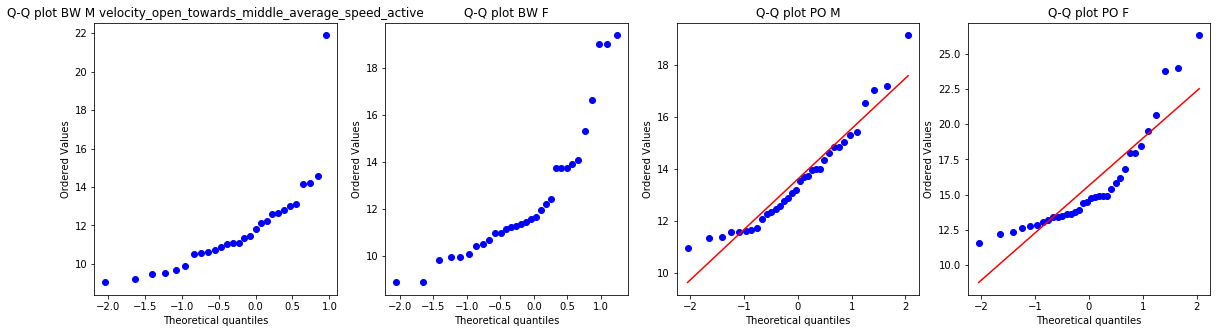

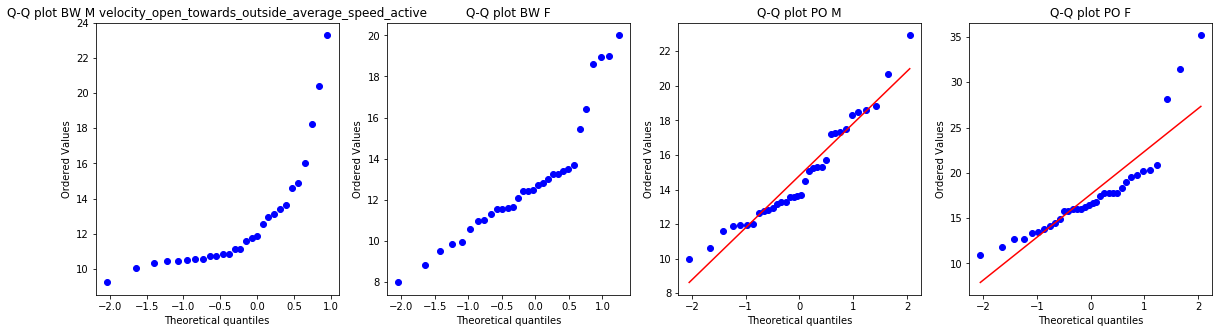

In [14]:
i=0
for feature in final_features:

    plt.subplots(1, 4, figsize=(20, 5))

    plt.subplot(1, 4, 1)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') &
                                    (df_bwpo['mouse_details_sex']=='M'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot BW M "+ feature)

    plt.subplot(1, 4, 2)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') &
                                    (df_bwpo['mouse_details_sex']=='F'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot BW F")

    plt.subplot(1, 4, 3)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO') &
                                    (df_bwpo['mouse_details_sex']=='M'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot PO M")

    plt.subplot(1, 4, 4)
    probplot(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO') &
                                    (df_bwpo['mouse_details_sex']=='F'), feature], dist="norm", plot=pylab)
    plt.title("Q-Q plot PO F")
             
    plt.show()

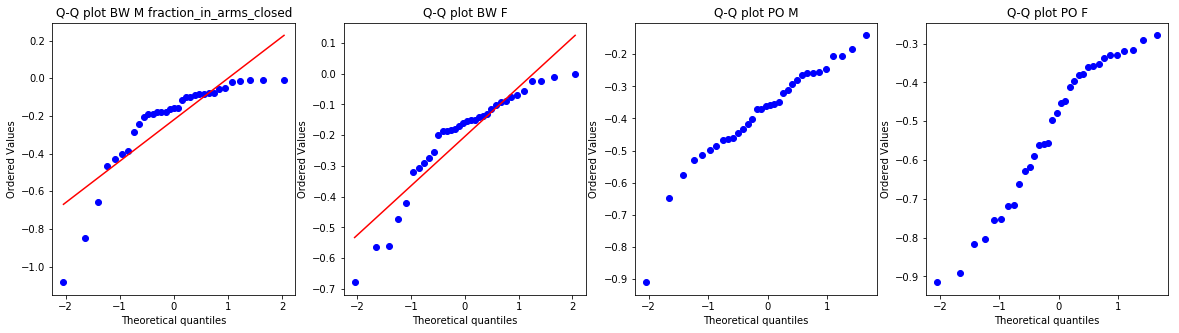

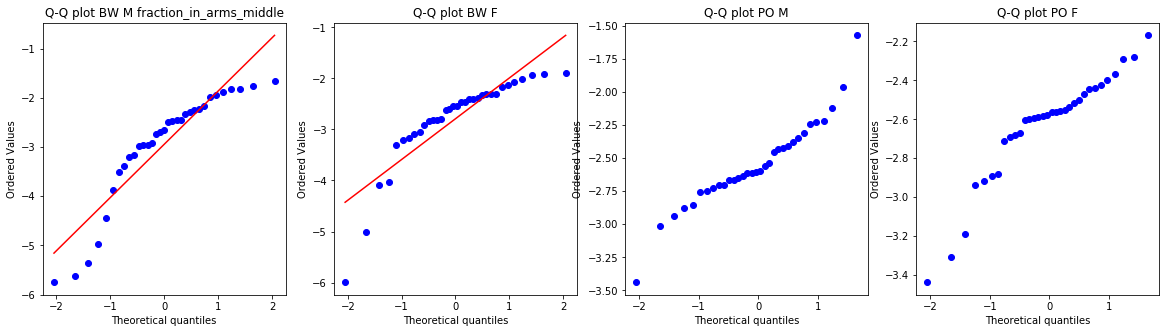

/Users/srinidhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/Users/srinidhi/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


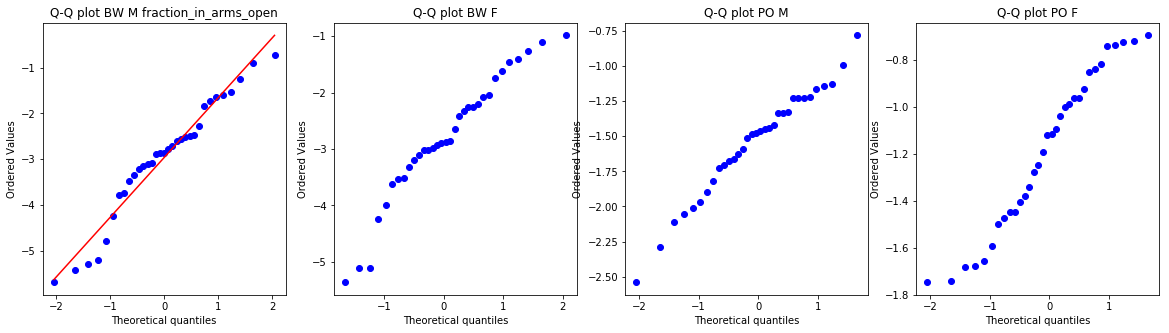

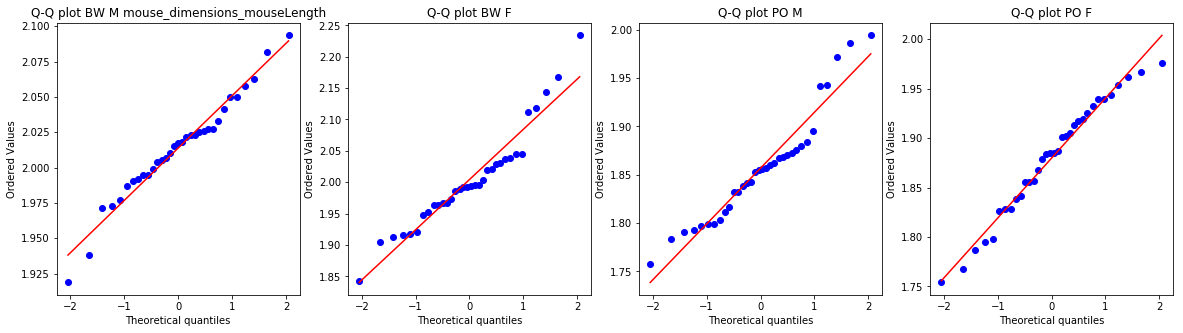

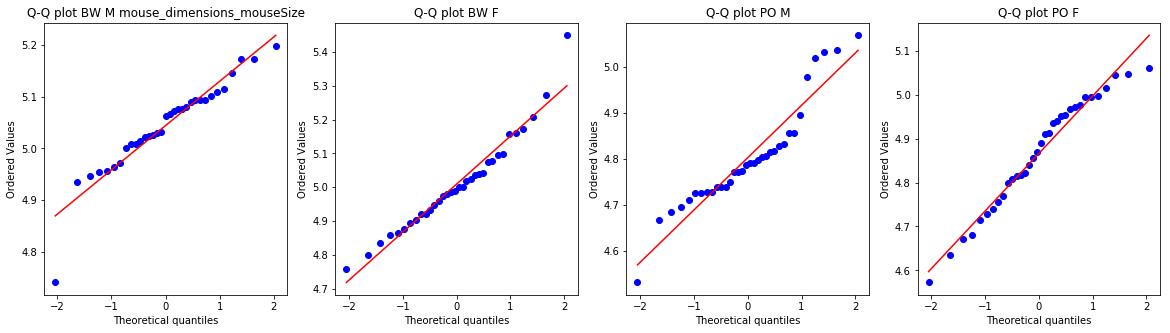

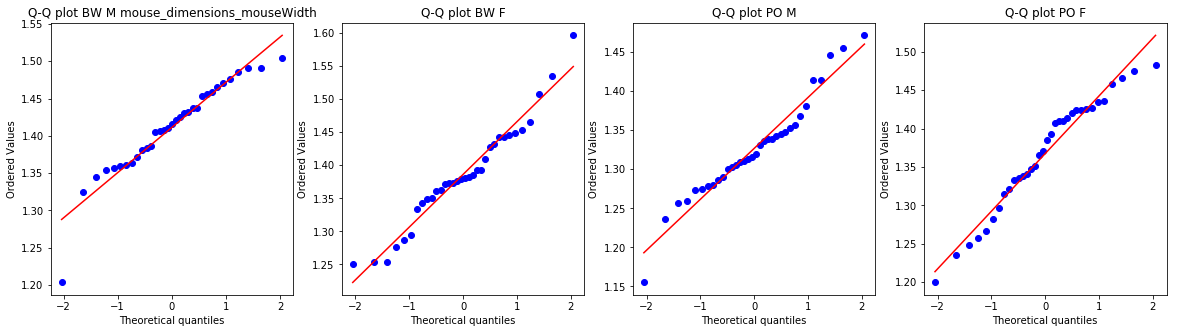

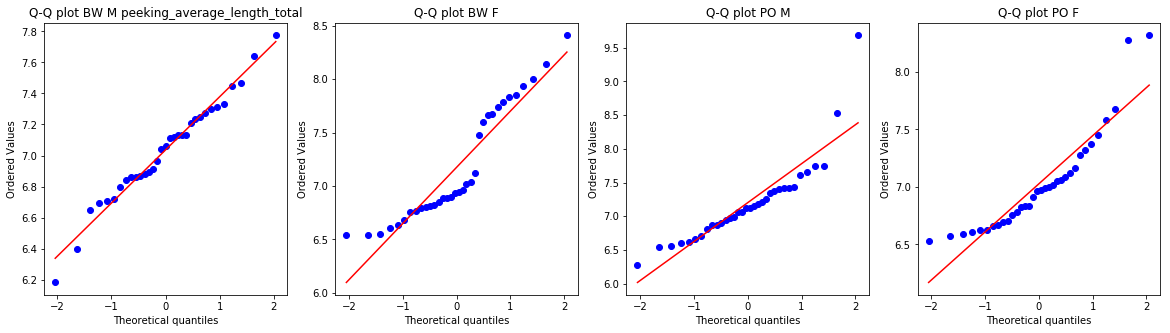

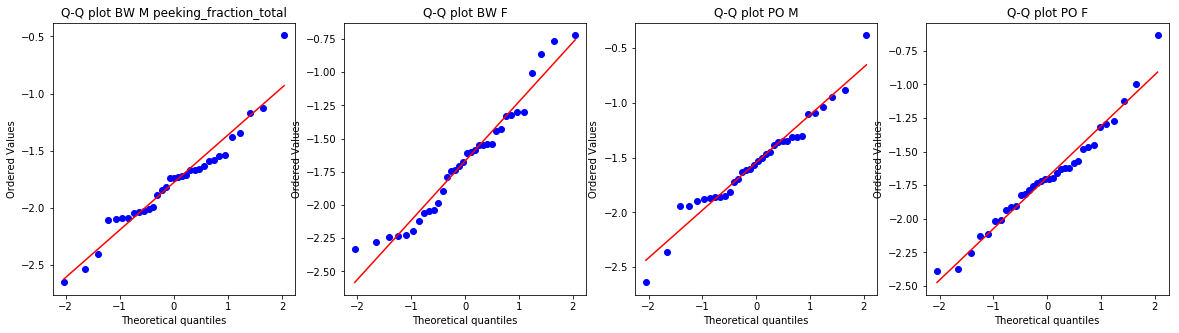

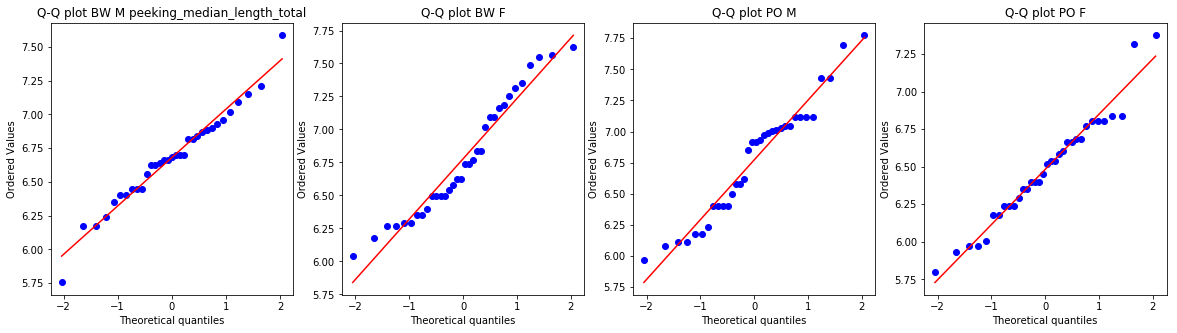

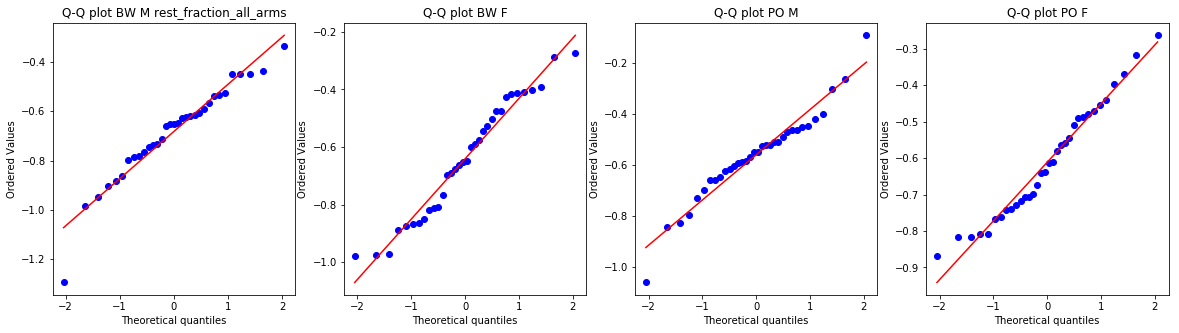

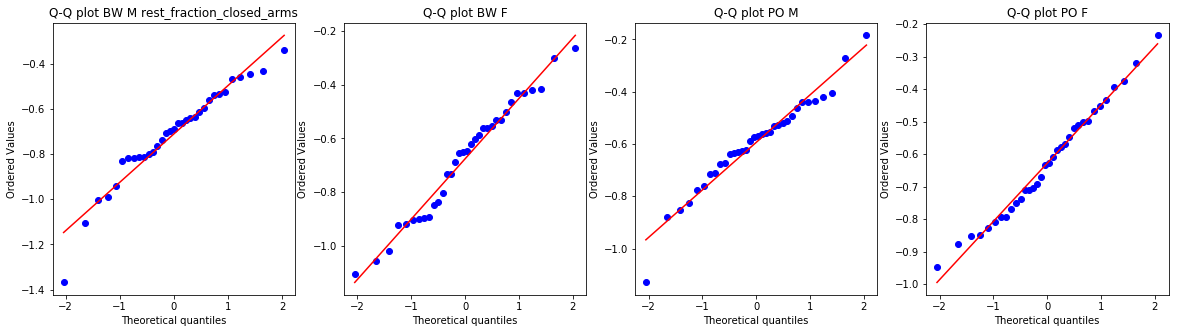

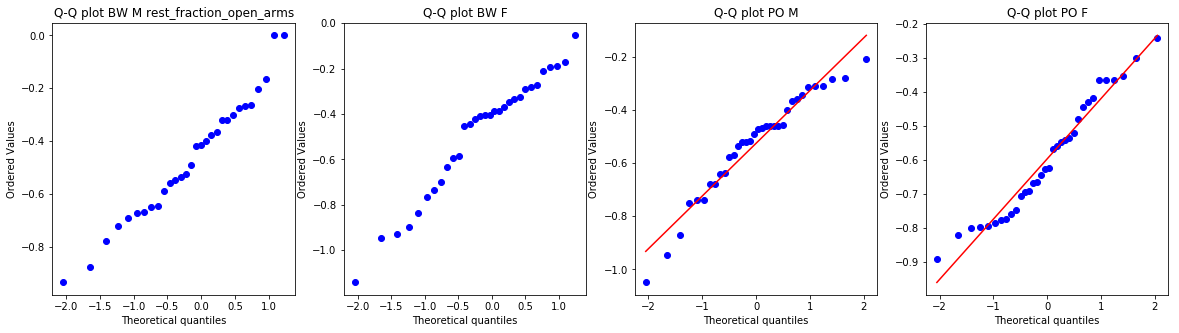

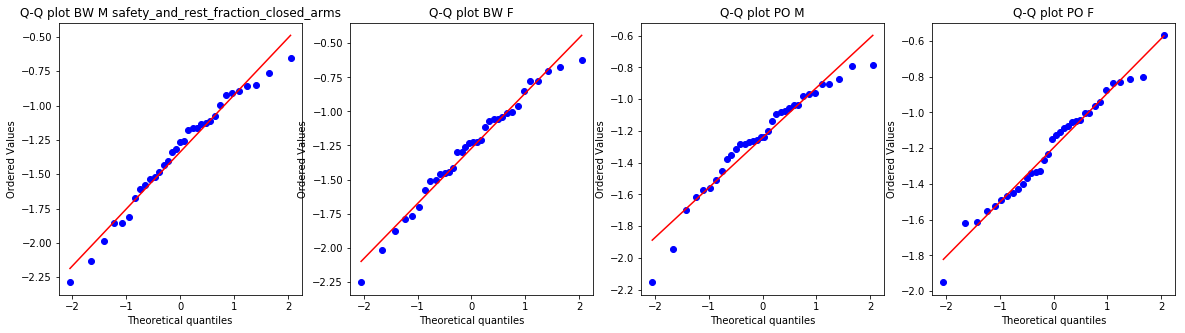

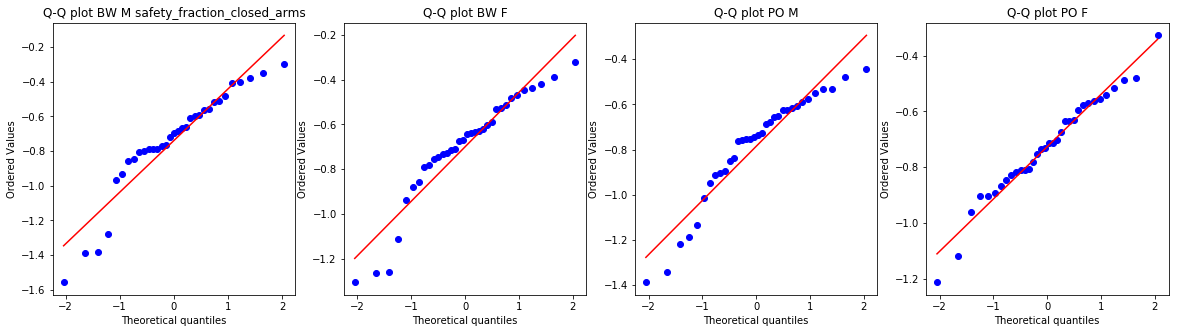

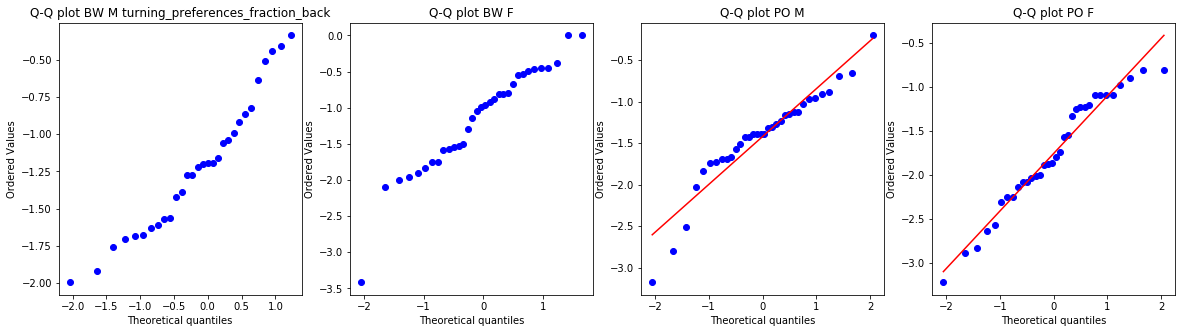

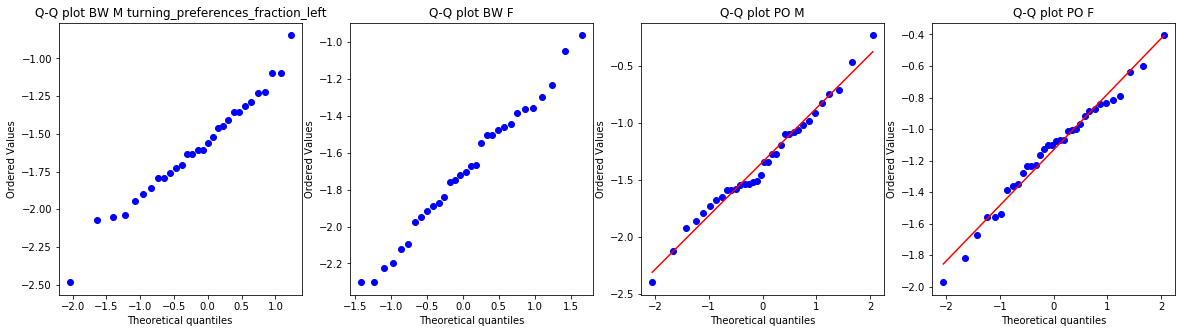

/Users/srinidhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


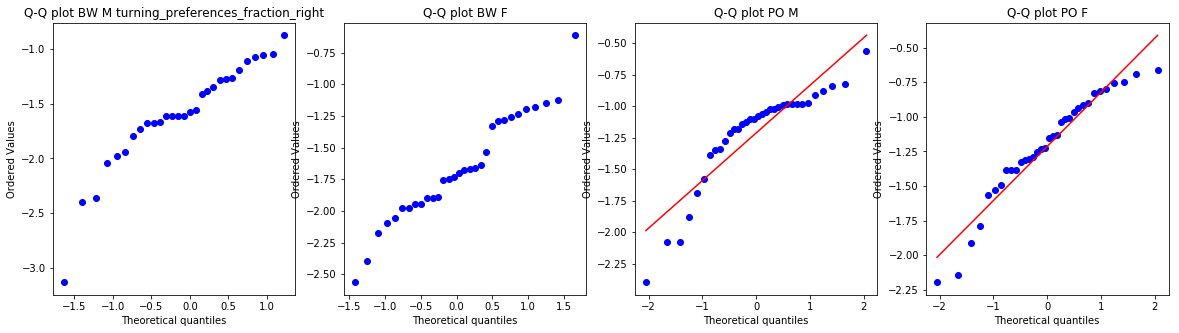

/Users/srinidhi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log


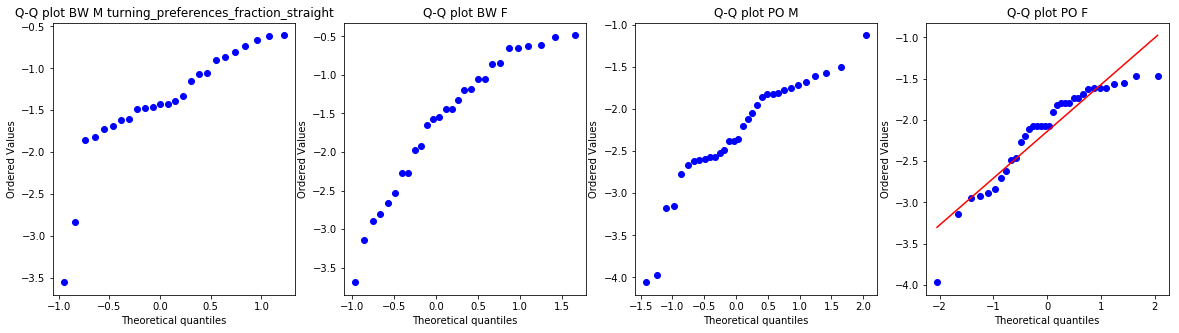

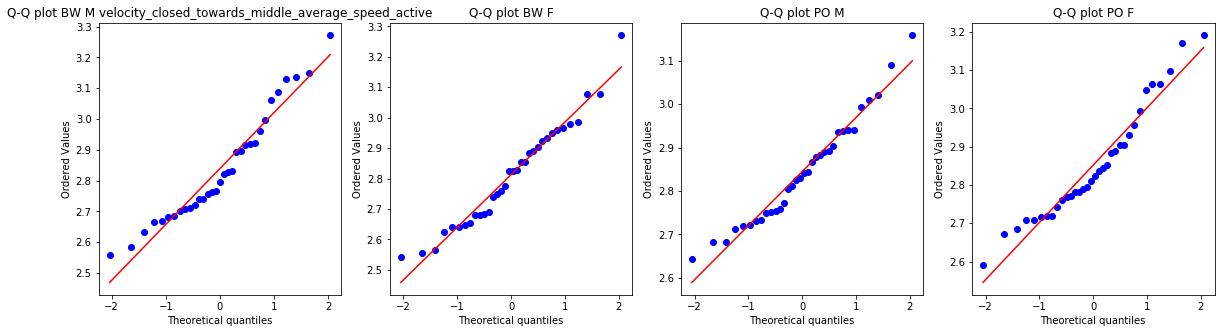

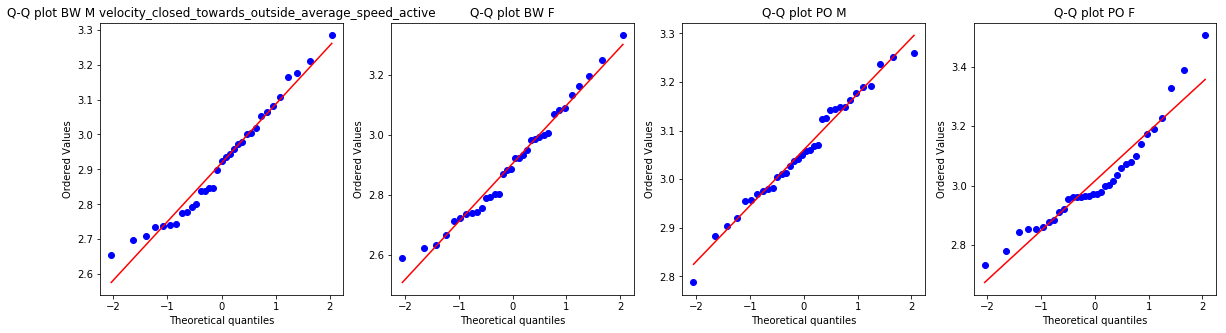

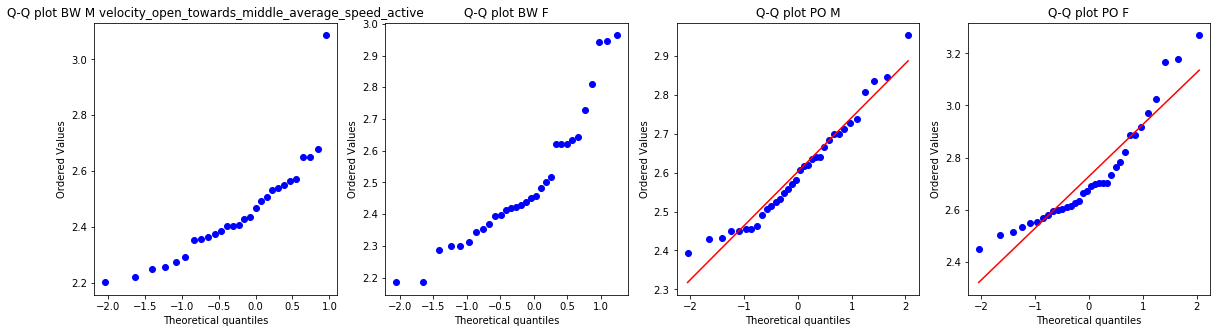

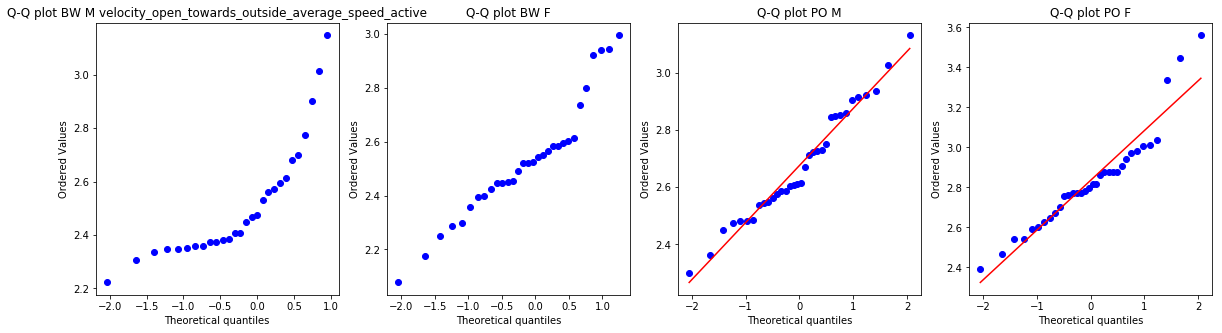

In [15]:
i=0
for feature in final_features:

    plt.subplots(1, 4, figsize=(20, 5))

    plt.subplot(1, 4, 1)
    probplot(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') &
                                    (df_bwpo['mouse_details_sex']=='M'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot BW M "+ feature)

    plt.subplot(1, 4, 2)
    probplot(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='BW') &
                                    (df_bwpo['mouse_details_sex']=='F'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot BW F")

    plt.subplot(1, 4, 3)
    probplot(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO') &
                                    (df_bwpo['mouse_details_sex']=='M'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot PO M")

    plt.subplot(1, 4, 4)
    probplot(np.log(df_bwpo.loc[(df_bwpo['mouse_details_strain']=='PO') &
                                    (df_bwpo['mouse_details_sex']=='F'), feature]), dist="norm", plot=pylab)
    plt.title("Q-Q plot PO F")
             
    plt.show()

In [74]:
# ANOVA

def anova(df, features, alpha_significance=0.05):

    ''' significance(df_features, features, alpha_normal=0.05, alpha_significance=0.05)
    Input: DataFrame of aggregated mice features, features, alpha levels
    Output: Normality_results, Feature significance, p-values'''
    
    #Initiate empty lists for results

    significance_species= []
    significance_sex= []
    significance_species_sex= []
    
    for feature in features:
        
        data = df.loc[(df[feature]!=0) ,['mouse_details_sex', 'mouse_details_strain', feature]].dropna()
#         data[feature] = np.log(data[feature])
        model = ols(feature+' ~ C(mouse_details_strain, Sum)*C(mouse_details_sex, Sum)', data=data).fit()
        table = sm.stats.anova_lm(model, typ=2) # Type 2 Anova DataFrame

        significance_species.append(table['PR(>F)'][0])
        significance_sex.append(table['PR(>F)'][1])
        significance_species_sex.append(table['PR(>F)'][2])
        
    return significance_species, significance_sex, significance_species_sex#, significance, stats_test_p

In [75]:
anova_species, anova_sex, anova_species_sex = anova(df_bwpo, final_features)

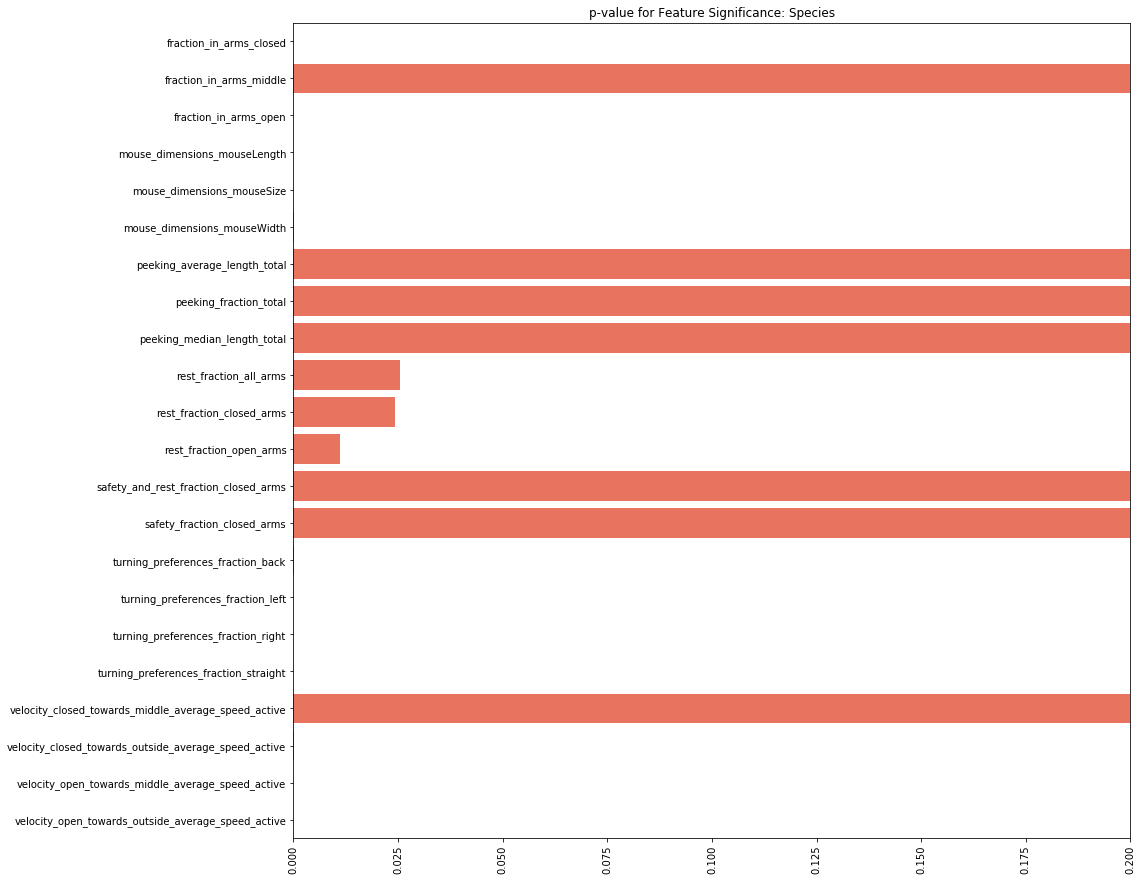

In [59]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance: Species")
sns.barplot(x=anova_species, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 0.2)
plt.show()

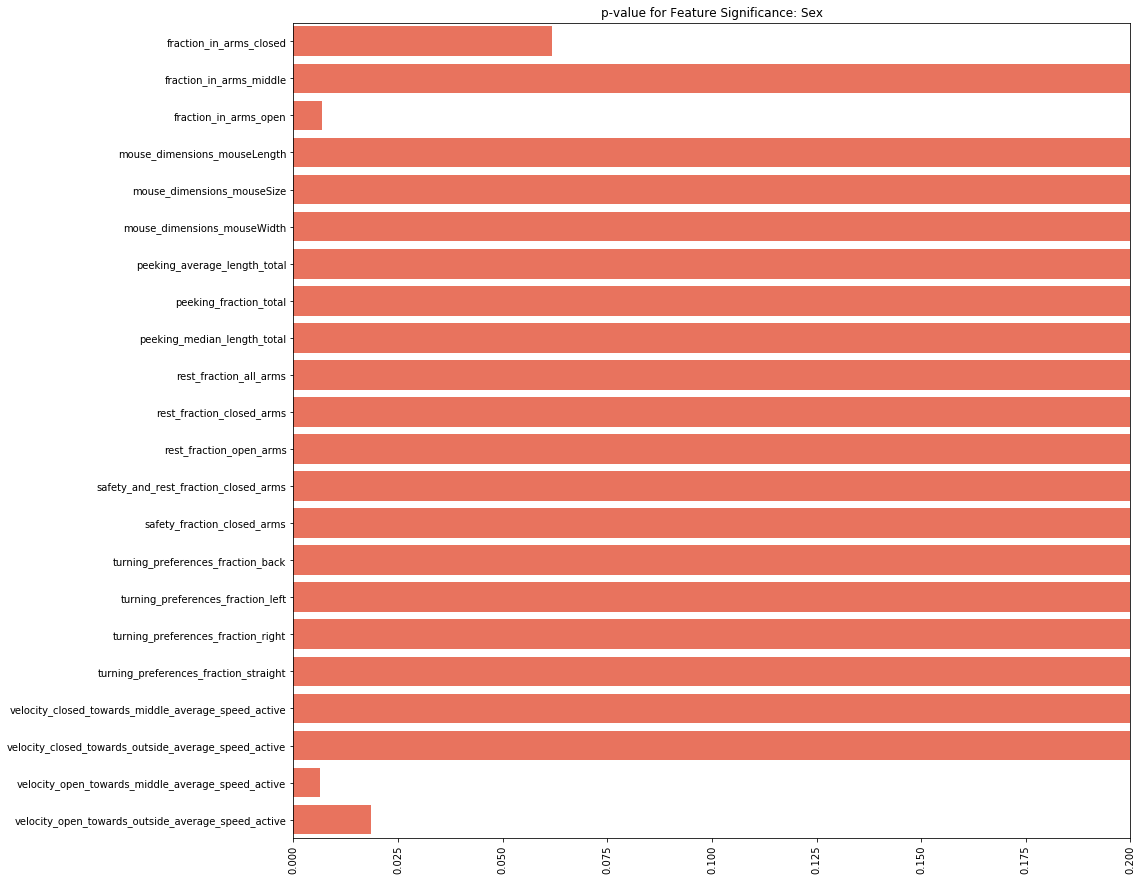

In [64]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance: Sex")
sns.barplot(x=anova_sex, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 0.2)
plt.show()

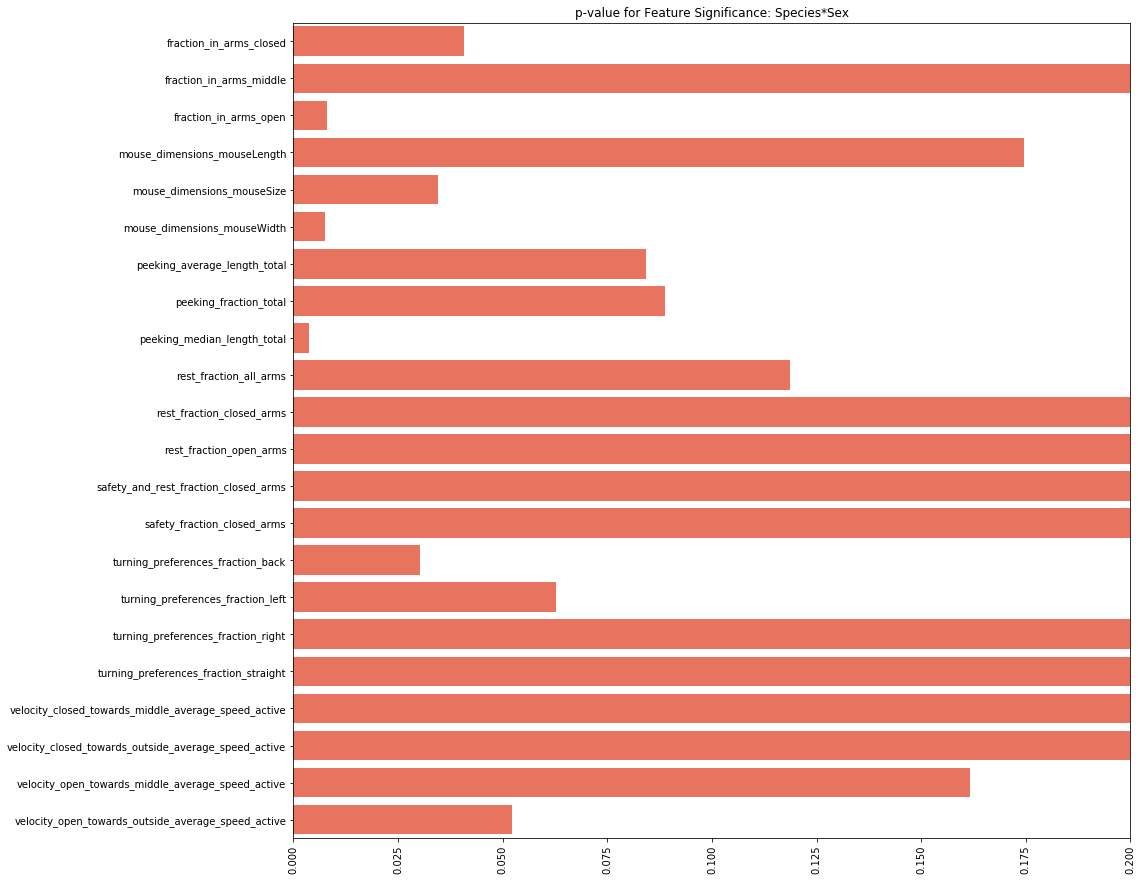

In [61]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance: Species*Sex")
sns.barplot(x=anova_species_sex, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 0.2)
plt.show()

In [54]:
final_features

['fraction_in_arms_closed',
 'fraction_in_arms_middle',
 'fraction_in_arms_open',
 'mouse_dimensions_mouseLength',
 'mouse_dimensions_mouseSize',
 'mouse_dimensions_mouseWidth',
 'peeking_average_length_total',
 'peeking_fraction_total',
 'peeking_median_length_total',
 'rest_fraction_all_arms',
 'rest_fraction_closed_arms',
 'rest_fraction_open_arms',
 'safety_and_rest_fraction_closed_arms',
 'safety_fraction_closed_arms',
 'turning_preferences_fraction_back',
 'turning_preferences_fraction_left',
 'turning_preferences_fraction_right',
 'turning_preferences_fraction_straight',
 'velocity_closed_towards_middle_average_speed_active',
 'velocity_closed_towards_outside_average_speed_active',
 'velocity_open_towards_middle_average_speed_active',
 'velocity_open_towards_outside_average_speed_active']

In [73]:
anova_species_sex

[0.019835564399840386,
 0.35823170880425503,
 0.5141193852870307,
 0.11816271345294815,
 0.017894214981083005,
 0.006788164758336387,
 0.06767207670276872,
 0.07530123848679164,
 0.00771999084119393,
 0.15107866218243002,
 0.3153658496583281,
 0.5323346635894812,
 0.8683928246059,
 0.8025992945689459,
 0.06614252620446577,
 0.021730730232658365,
 0.6518503285581969,
 0.1877670264430449,
 0.5300659617674239,
 0.5734421013246046,
 0.2270601650211306,
 0.07660322615270963]

In [23]:
np.array(final_features)[np.array(anova_species)<0.05]

array(['fraction_in_arms_closed', 'fraction_in_arms_open',
       'mouse_dimensions_mouseLength', 'mouse_dimensions_mouseSize',
       'mouse_dimensions_mouseWidth', 'rest_fraction_all_arms',
       'rest_fraction_closed_arms', 'rest_fraction_open_arms',
       'turning_preferences_fraction_back',
       'turning_preferences_fraction_left',
       'turning_preferences_fraction_right',
       'turning_preferences_fraction_straight',
       'velocity_closed_towards_outside_average_speed_active',
       'velocity_open_towards_middle_average_speed_active',
       'velocity_open_towards_outside_average_speed_active'], dtype='<U52')

In [62]:
np.array(final_features)[np.array(anova_sex)<0.05]

array(['fraction_in_arms_open',
       'velocity_open_towards_middle_average_speed_active',
       'velocity_open_towards_outside_average_speed_active'], dtype='<U52')

In [63]:
np.array(final_features)[np.array(anova_species_sex)<0.05]

array(['fraction_in_arms_closed', 'fraction_in_arms_open',
       'mouse_dimensions_mouseSize', 'mouse_dimensions_mouseWidth',
       'peeking_median_length_total', 'turning_preferences_fraction_back'],
      dtype='<U52')

In [64]:
np.array(final_features)[(np.array([norm[0] for norm in normal_count]) <3) & (np.array([norm[1] for norm in normal_count]) <3)]

array(['peeking_average_length_total',
       'velocity_open_towards_middle_average_speed_active',
       'velocity_open_towards_outside_average_speed_active'], dtype='<U52')

Species: [‘fraction_in_arms_closed’,
      ‘fraction_in_arms_open’, ‘mouse_dimensions_mouseLength’, ‘rest_fraction_all_arms’,
      ‘rest_fraction_closed_arms’, ‘rest_fraction_open_arms’,
      ‘turning_preferences_fraction_back’,
      ‘turning_preferences_fraction_left’,
      ‘turning_preferences_fraction_right’,
      ‘turning_preferences_fraction_straight’,
      ‘velocity_closed_towards_outside_average_speed_active’,
      ‘velocity_open_towards_middle_average_speed_active’,
      ‘velocity_open_towards_outside_average_speed_active’]

Sex: [‘velocity_open_towards_middle_average_speed_active’,
      ‘velocity_open_towards_outside_average_speed_active’]

Species*Sex: [‘fraction_in_arms_closed’, ‘mouse_dimensions_mouseLength’,
              ‘turning_preferences_fraction_left’]
       
Normal: ['fraction_in_arms_middle',
        'mouse_dimensions_mouseLength',
       'rest_fraction_all_arms', 'rest_fraction_closed_arms',
       'rest_fraction_open_arms', 
       'turning_preferences_fraction_right',
       'turning_preferences_fraction_straight',
       'velocity_closed_towards_outside_average_speed_active',
       'velocity_closed_towards_middle_average_speed_active']
       
Normal with log: ['fraction_in_arms_open', 'turning_preferences_fraction_left', 'turning_preferences_fraction_back']
       
Not normal with any transformation: ['fraction_in_arms_closed', 'velocity_open_towards_middle_average_speed_active',
       'velocity_open_towards_outside_average_speed_active']

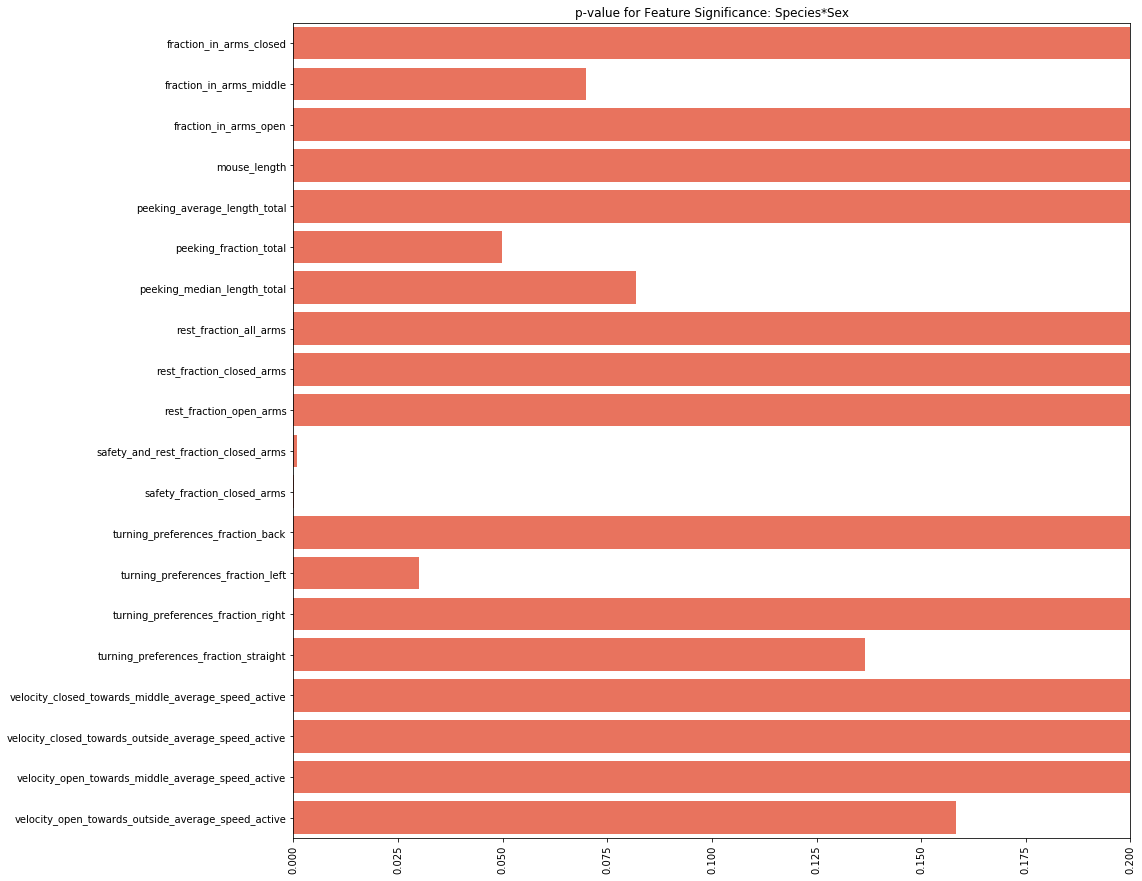

In [37]:
plt.figure(figsize=(15, 15))
plt.title("p-value for Feature Significance: Species*Sex")
sns.barplot(x=anova_species_sex, y=final_features, color='tomato')
plt.xticks(rotation= 90)
plt.xlim(0, 0.2)
plt.show()

In [164]:
df_bwpo.groupby(['mouse_details_strain', 'mouse_details_sex'])['velocity_open_towards_outside_average_speed_active'].mean()

mouse_details_strain  mouse_details_sex
BW                    F                    65.400408
                      M                    60.705625
PO                    F                    89.819984
                      M                    73.486559
Name: velocity_open_towards_outside_average_speed_active, dtype: float64

In [186]:
df_bwpo.groupby(['mouse_details_strain', 'mouse_details_sex'])['turning_preferences_fraction_left'].mean()

mouse_details_strain  mouse_details_sex
BW                    F                    0.183599
                      M                    0.211895
PO                    F                    0.326726
                      M                    0.254545
Name: turning_preferences_fraction_left, dtype: float64

In [189]:
df_bwpo.groupby(['mouse_details_strain', 'mouse_details_sex'])['fraction_in_arms_closed'].mean()

mouse_details_strain  mouse_details_sex
BW                    F                    0.842421
                      M                    0.896130
PO                    F                    0.658749
                      M                    0.709610
Name: fraction_in_arms_closed, dtype: float64

In [215]:
df_bwpo.loc[df_bwpo['turning_preferences_fraction_right']!=0, ].groupby(['mouse_details_strain', 'mouse_details_sex'])['turning_preferences_fraction_right'].mean()

mouse_details_strain  mouse_details_sex
BW                    F                    0.204468
                      M                    0.198474
PO                    F                    0.284197
                      M                    0.331542
Name: turning_preferences_fraction_right, dtype: float64

In [203]:
df_bwpo.loc[df_bwpo['fraction_in_arms_open']!=0, ].shape

(83, 218)

In [207]:
final_features

['fraction_in_arms_closed',
 'fraction_in_arms_middle',
 'fraction_in_arms_open',
 'mouse_length',
 'peeking_average_length_total',
 'peeking_fraction_total',
 'peeking_median_length_total',
 'rest_fraction_all_arms',
 'rest_fraction_closed_arms',
 'rest_fraction_open_arms',
 'safety_and_rest_fraction_closed_arms',
 'safety_fraction_closed_arms',
 'turning_preferences_fraction_back',
 'turning_preferences_fraction_left',
 'turning_preferences_fraction_right',
 'turning_preferences_fraction_straight',
 'velocity_closed_towards_middle_average_speed_active',
 'velocity_closed_towards_middle_median_speed_active',
 'velocity_closed_towards_outside_average_speed_active',
 'velocity_closed_towards_outside_median_speed_active',
 'velocity_open_towards_middle_average_speed_active',
 'velocity_open_towards_middle_median_speed_active',
 'velocity_open_towards_outside_average_speed_active',
 'velocity_open_towards_outside_median_speed_active']

In [275]:
anova_species

[1.0098301224574546e-17,
 0.0354949118314047,
 3.8712741050603493e-20,
 6.568023771901551e-16,
 0.1348546559525753,
 0.0394011818730719,
 0.46834954685810837,
 0.00975061869468239,
 0.007240202748774049,
 0.009982787339001672,
 0.1625648010768755,
 0.4528270855939418,
 0.018429038403761634,
 5.930463559323842e-06,
 4.443535903200305e-06,
 4.399404892930012e-08,
 0.050886307135801646,
 0.2668295137811015,
 6.852813081906517e-06,
 4.374878434230774e-05,
 0.0015522041970681421,
 0.018903700542149782,
 1.3618603752023584e-05,
 0.00023462042559704594]

In [76]:
# (BW-PO)/BW

for feature in final_features:
    print(feature + ' ' + str((df_bwpo.loc[df_bwpo[feature]!=0, ].groupby(['mouse_details_strain'])[feature].mean()['BW']-df_bwpo.loc[df_bwpo[feature]!=0, ].groupby(['mouse_details_strain'])[feature].mean()['PO'])/
          (df_bwpo.loc[df_bwpo[feature]!=0, ].groupby(['mouse_details_strain'])[feature].mean()['BW'])))
          

fraction_in_arms_closed 0.21590741633789418
fraction_in_arms_middle -0.006498019887351553
fraction_in_arms_open -1.768856801198591
mouse_dimensions_mouseLength 0.13138636981589205
mouse_dimensions_mouseSize 0.17411595844343727
mouse_dimensions_mouseWidth 0.050117464112721395
peeking_average_length_total -0.13003287827923402
peeking_fraction_total -0.0995167986420044
peeking_median_length_total 0.08154255782233977
rest_fraction_all_arms -0.07301315779822398
rest_fraction_closed_arms -0.07811187153682826
rest_fraction_open_arms 0.09240141453751688
safety_and_rest_fraction_closed_arms -0.05473628411563789
safety_fraction_closed_arms 0.04753329485183845
turning_preferences_fraction_back 0.3278266558322781
turning_preferences_fraction_left -0.5386917181416417
turning_preferences_fraction_right -0.48116950713754364
turning_preferences_fraction_straight 0.5435131084697089
velocity_closed_towards_middle_average_speed_active -0.01692464891048899
velocity_closed_towards_outside_average_speed_act

In [114]:
22.5/82.5

0.2727272727272727

In [115]:
df_bwpo.loc[df_bwpo['velocity_open_towards_middle_average_speed_active']!=0, ].groupby(['mouse_details_strain', 'mouse_details_sex'])['velocity_open_towards_middle_average_speed_active'].mean()



mouse_details_strain  mouse_details_sex
BW                    F                    12.457036
                      M                    11.834492
PO                    F                    15.640816
                      M                    13.622020
Name: velocity_open_towards_middle_average_speed_active, dtype: float64

In [105]:
6/32.9

0.182370820668693

In [243]:
df_bwpo.loc[df_bwpo['fraction_in_arms_closed']!=0, ].groupby(['mouse_details_strain', 'mouse_details_sex'])['fraction_in_arms_closed'].mean()



mouse_details_strain  mouse_details_sex
BW                    F                    0.842421
                      M                    0.896130
PO                    F                    0.658749
                      M                    0.709610
Name: fraction_in_arms_closed, dtype: float64

In [241]:
267/88

3.034090909090909

In [242]:
209/48

4.354166666666667

In [245]:
84/66

1.2727272727272727

In [274]:
df_bwpo.loc[df_bwpo['turning_preferences_fraction_left']!=0, ].groupby(['mouse_details_sex', 'mouse_details_strain'])['turning_preferences_fraction_left'].mean()

mouse_details_sex  mouse_details_strain
F                  BW                      0.190156
                   PO                      0.326726
M                  BW                      0.211895
                   PO                      0.262259
Name: turning_preferences_fraction_left, dtype: float64

In [ ]:
Turn:
    Species: M: -24%  F: -72%
    Sex: BW: 10% PO: -24%

Safety:
    Species: M: 18%  F: -13% 
    Sex: BW: 10% PO: -25%


In [273]:
1-(444/541)

0.1792975970425139

In [25]:
df_bwpo['turning_preferences_fraction_back']

0       0.301887
1       0.208333
4       0.333333
5       0.176471
6       0.291667
15      0.250000
17      0.133333
18      0.250000
19      0.312500
36      0.422222
37      0.204545
38      0.140351
39           NaN
40      0.529412
41      0.302326
42      0.714286
44      0.333333
45      0.292683
46      0.297297
47      0.317073
48      0.177419
49      0.222222
50      0.175000
51      0.250000
52      0.185185
68      0.280000
69      0.206897
70      0.358974
71      0.189189
72      0.100000
          ...   
1731    0.303371
1732         NaN
1733    0.186813
1734    0.375000
1735    0.125000
1736    0.151515
1737    0.155172
1738    0.130435
1739    0.370370
1740    0.185185
1741    0.280000
1742    0.135922
1743    0.209302
1744    0.222222
1745    0.444444
1746    0.173333
1747    0.153846
1748    0.333333
1749    0.117647
1750    0.134615
1751    0.166667
1752    0.058824
1753    0.076923
1754    0.040000
1755    0.105263
1756    0.041667
1757    0.071429
1758    0.1250